# PubChem validation
This notebook demonstrates a new (?) idea in LBVS validation - pinging the pubchem server for assays for a given compound / target pair, and assessing the Outcome field. 

The main difficulty/novelty here is automating the approach while ensuring it gets the CORRECT assay. This is because many targets have different names, and there is no standard format for assay descriptions *or* outcomes.

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import pandas as pd
from pprint import pprint

import re

from tqdm import tqdm_notebook

import scipy
from scipy import sparse
from scipy import stats

import pubchempy as pcp
from chembl_webresource_client.new_client import new_client 
import json
import requests

import copy

import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

import sys
sys.path.append("..")
import utils
import numpy as np

/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '


# Make some structure-predictions with label correlations:



In [2]:
#all labels:
interaction_matrix = sparse.load_npz('../0_data/interaction_matrix_pchembl.npz')
smiles = pd.read_csv('../0_data/pchembl_chemicals.csv')
targets_df= pd.read_csv('../0_data/subset_targets.csv')

In [3]:
probability_matrix = utils.train_label_correlation(interaction_matrix)

  0%|          | 280/85681 [00:00<00:30, 2790.01it/s]

y_in shape is: (337951, 243)


100%|██████████| 337951/337951 [00:49<00:00, 6856.65it/s]


In [4]:
train, test, fps = utils.load_time_split(year=2030, 
                                         return_fingerprints=True) #set a year after now to get ALL records

probability_arr = probability_matrix.toarray()

In [5]:
##sort the predictions in order of probability, highest first. 

arr = probability_matrix.toarray()
arr = arr - interaction_matrix
arr_sorted = np.dstack(np.unravel_index(np.argsort(-arr.ravel()), (arr.shape[0], arr.shape[1])))[0]
print('Should be a high number < 1:')
print(probability_arr[arr_sorted[0][0]][arr_sorted[0][1]])
print('Should be a low number >= 0:')
print(probability_arr[arr_sorted[-1][0]][arr_sorted[-1][1]])
print('Sorted array indices:')
arr_sorted

Should be a high number < 1:
0.99991256
Should be a low number >= 0:
0.0
Sorted array indices:


array([[328242,    138],
       [ 68104,    138],
       [315225,     72],
       ...,
       [132327,     26],
       [132327,     28],
       [337950,    242]])

In [6]:
#sanity check - make sure the ligand IDX, smiles, and target IDX and target names line up:

for pair in arr_sorted[:10]:
    smi = smiles['canonical_smiles'].iloc[pair[0]]
    chembl_id = smiles['instance_id'].iloc[pair[0]]
    predicted_target = targets_df['pref_name'].iloc[pair[1]]
    tid = targets_df[targets_df['pref_name']==predicted_target]['pref_name'].iloc[0]
    print(smi[:10]+'...', predicted_target, '\t', tid)
    print(chembl_id, smi)

C[C@@H](Oc... Vascular endothelial growth factor receptor 2 	 Vascular endothelial growth factor receptor 2
CHEMBL601719 C[C@@H](Oc1cc(cnc1N)c2cnn(c2)C3CCNCC3)c4c(Cl)ccc(F)c4Cl
Nc1ncnc2sc... Vascular endothelial growth factor receptor 2 	 Vascular endothelial growth factor receptor 2
CHEMBL1998585 Nc1ncnc2scc(c3ccc(NC(=O)Nc4cc(ccc4F)C(F)(F)F)cc3)c12
CCN(CC)CCN... Serine/threonine-protein kinase PIM1 	 Serine/threonine-protein kinase PIM1
CHEMBL535 CCN(CC)CCNC(=O)c1c(C)[nH]c(\C=C\2/C(=O)Nc3ccc(F)cc23)c1C
CNC(=O)c1c... Vascular endothelial growth factor receptor 2 	 Vascular endothelial growth factor receptor 2
CHEMBL2005631 CNC(=O)c1cnc(N)c2c(csc12)c3ccc(NC(=O)Nc4cc(C)ccc4F)cc3
Cn1cc(cn1)... Vascular endothelial growth factor receptor 2 	 Vascular endothelial growth factor receptor 2
CHEMBL1988717 Cn1cc(cn1)c2cnn3c(N)c(cnc23)c4ccc(NC(=O)Nc5cccc(c5)C(F)(F)F)cc4
Cc1ccc(NC(... Vascular endothelial growth factor receptor 2 	 Vascular endothelial growth factor receptor 2
CHEMBL2000335 Cc1ccc

# PubChem-pinging 

This became much cleaner when wrapped in a class. The below uses a class to perform a number of functions:

- save/load checkpoints - i.e. if something breaks, or you want to come back to this later after shutting the laptop, you can save all the data and load it afterwards to pick back up
- ping `pubchempy` for compound ID (CID) numbers.
- ping `chembl_webresource_client` for target synonyms
- ping pubchem REST API for assays associated with a CID
- records all of this stuff in dicts to be saved as JSON so I can parse it later. 

In [7]:
from pubval import PubChemValidator
pcv = PubChemValidator(targets_df, interaction_matrix, fps)
#pcv.targets = {}

# How many predictions to sample, and which ones?

Ideally we want to sample a good few predictions that have high probabilities. But we also want to see how well it performs at lower probabilities. The problem is that even sampling over the highest, say, 10,000,000 predictions will be highly biased toward lower probabilities! So we try to weight the random selection to balance it out, selection an even number of high- and low-scoring predictions.

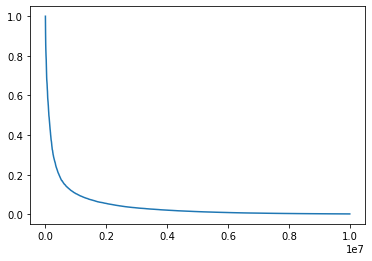

In [8]:
num = 10_000_000
probs = probability_arr[arr_sorted[:,0][:num], arr_sorted[:,1][:num]]
plt.plot(probs)

In [36]:
n = 10_000_000
take = 40000

weight = 1 / ((np.arange(n)**1.25)/(0.1*take)+1)
weight = weight/weight.sum()

sample = np.random.choice(n, take, p=weight, replace=False)

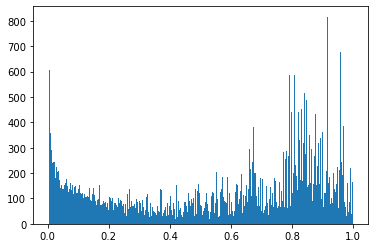

In [37]:
sample_arr = arr_sorted[sample]

_ = plt.hist(probability_arr[sample_arr[:,0][:num], sample_arr[:,1][:num]], bins=300)

# Do the sampling.


In [38]:
pcv.load_checkpoint()

In [39]:
##resetting predictions because I made a previous mistake in calculating nnranks
#pcv.predictions = {}

In [40]:
for count, prediction in enumerate(arr_sorted[sample]):
    print(prediction)
    ligand_idx = prediction[0]
    target_idx = prediction[1]
    probability = probability_arr[ligand_idx][target_idx]
    
    try:
        if not pcv.has_ligand(ligand_idx):
            pcv.create_ligand(ligand_idx)
        
        if not pcv.has_target(target_idx):
            pcv.create_target(target_idx)
        
        if not pcv.has_prediction(ligand_idx, target_idx):
            pcv.create_prediction(ligand_idx, target_idx, probability)
        
    except KeyboardInterrupt:
        raise
    except Exception:
        pass
    
    if count>0 and count%50==0:
        pcv.save_checkpoint()

[97831   127]
[207869    154]
[58245    72]
[147898    127]
[67469    72]
[282938    116]
[249880     84]
[238044    104]
[282998    116]
[46165    98]
[66080   138]
[142970    127]
[83796    14]
[156621     75]
[198445    215]
[141413     64]
[187592     79]
[67289   136]
[97834    52]
[186888    233]
[73631     9]
[106889    164]
[279425    166]
[82075   165]
[66961   178]
[109954     90]
[333728    170]
[276401    138]
[298128     90]
[23364    91]
[67985   224]
[66584   157]
[334297    112]
[102333     95]
[335917     82]
[93696    36]
[277995    127]
[122315    179]
[283374    166]
[9341   81]
[117659     94]
[68364   215]
[132892     82]
[109387     29]
[332552     76]
[161643     95]
[298713    177]
[131406     52]
[43391   170]
[120961     90]
[68194    16]
[83392   149]
[294762     76]
[109666    224]
[188503    198]
[219524     84]
[126466    167]
[131398     52]
[162910     52]
[321587    127]
[1739   90]
[4534  142]
[93082   116]
[83653   127]
[142590    177]
[276858    127

[329448    121]
[93928    52]
[203557    194]
[305802    149]
[223728    170]
[295831    100]
[200142     31]
[105513     76]
[185623    149]
[98620   177]
[83463   127]
[160400     83]
[157041    162]
[133129     52]
[146813     82]
[2998  233]
[108590     14]
[26497   225]
[191445     64]
[275234    149]
[311721     82]
[98988   127]
[86029   130]
[228275    166]
[281790     82]
[167016    191]
[257870    199]
[49780   169]
[302338    103]
[225389    177]
[1338   98]
[66235   142]
[2977  122]
[110851     52]
[49953   196]
[218221    127]
[139918     90]
[227486     79]
[67934   168]
[58466   233]
[36210    90]
[49028    63]
[68287   199]
[125944    179]
[8104  169]
[66238    48]
[113187    140]
[204975    187]
[183515    166]
[194514    191]
[265043    214]
[194560    138]
[250479     72]
[52409   177]
[153682     98]
[331472    127]
[217403    166]
[135660    202]
[153857    120]
[259971    165]
[277203     32]
[40070   237]
[257274    193]
[225510     16]
[275979    154]
[133132   

[255908     91]
[217725    127]
[284128    142]
[139714     76]
[320184    138]
[36519   116]
[159244     73]
[330987     84]
[24946    86]
[109870    127]
[111030     11]
[35639   170]
[68242    11]
[234162    138]
[335665    103]
[330231    171]
[304951    166]
[110863     52]
[50259    90]
[201028    178]
[3644  214]
[310264    224]
[25988    95]
[120286    198]
[122576     86]
[62898    80]
[217908    127]
[6430  149]
[67787   142]
[158030     53]
[16090   144]
[57032   214]
[255908     76]
[67806   215]
[133137    127]
[66262   142]
[308793    214]
[328242    138]
[144011     52]
[155362     52]
[200101    204]
[256364    225]
[50209    81]
[254050     53]
[171152    149]
[316943     90]
[68287    79]
[250992    102]
[201425    187]
[330564     94]
[221618    166]
[58003   214]
[160708     52]
[68211   138]
[147590    149]
[68489    79]
[279662    166]
[33562   225]
[320656    237]
[246949    109]
[178182    161]
[17087   180]
[97834   127]
[158924    170]
[96307   167]
[143898   

[103430     52]
[10566   138]
[90436   132]
[322571    103]
[67698    29]
[7997  159]
[58250    72]
[162638    175]
[66714    29]
[21455    76]
[38062   123]
[67255   224]
[38214    95]
[188803    149]
[66849    13]
[73935    88]
[310061     52]
[187593    202]
[132702     52]
[61216   167]
[150911    125]
[329189     76]
[277245    127]
[328060    205]
[100553     36]
[171428    142]
[68571    72]
[169161    121]
[110639     31]
[262804     84]
[6040  128]
[221090    150]
[68104   131]
[282091     81]
[305038    166]
[38915   112]
[11472     6]
[336208    127]
[81171   155]
[57881   155]
[276467    166]
[40541   165]
[188496    149]
[309260     52]
[253238     86]
[184041    142]
[193544    138]
[105048     73]
[16079   155]
[327794    103]
[135611    169]
[269043    138]
[199521    194]
[275129     73]
[144026     52]
[21511   112]
[23338   160]
[165645    125]
[333326     86]
[67435    72]
[233777     72]
[163387     33]
[253684     35]
[180989    159]
[211759    228]
[260036     73

[65456   194]
[110845    127]
[331009    116]
[330984    139]
[146430     52]
[150637     31]
[118276    204]
[248499    237]
[255285    126]
[132373    127]
[28950   100]
[123266     88]
[48775   103]
[77419    88]
[66155    73]
[117281    122]
[65788    90]
[194511    138]
[218242    144]
[158157    177]
[85913   121]
[66590   194]
[66681   138]
[333230     91]
[217564     52]
[296657     48]
[34533   170]
[42838    91]
[212254    236]
[144024     52]
[301358     36]
[164342    127]
[133125     52]
[259481      8]
[270363    134]
[164261     90]
[74107   108]
[130466    170]
[67449   149]
[243633     46]
[207567    100]
[185597    149]
[324147     63]
[68059   154]
[103732     16]
[68215   142]
[79785    76]
[38212   102]
[95979   191]
[104940     36]
[61895    52]
[26011   177]
[26669    52]
[209199    136]
[109949     90]
[217060    127]
[3222  233]
[84381   149]
[328764     98]
[181 177]
[329829    177]
[300071    122]
[4774  128]
[61715   181]
[49873   177]
[160346    178]
[29611

[105984    148]
[162727    177]
[68182    29]
[110331     67]
[131577    149]
[75679    18]
[225147      8]
[57083    88]
[67575   150]
[263169     14]
[67033    48]
[109758    112]
[300182     80]
[11657    90]
[214500    205]
[337845    113]
[207689    154]
[1953  166]
[262148     11]
[324902     64]
[196050    119]
[144028     52]
[262690    138]
[151082      9]
[134431     82]
[88388    49]
[212254    196]
[330501     84]
[12 67]
[70591   177]
[326699     98]
[135871    149]
[294923    136]
[15946   154]
[66998    13]
[49412    29]
[189040    166]
[171632     68]
[194533    138]
[20462   145]
[145139     18]
[146940     90]
[174129    128]
[58248    72]
[67124    79]
[130652    191]
[322494     88]
[66040   138]
[250788    215]
[247011    214]
[162894    165]
[96028    90]
[66041   215]
[171129    142]
[162909     52]
[82032    82]
[153221    144]
[67283   138]
[305192    166]
[337079     62]
[105150     72]
[255097    127]
[276203    199]
[132569     52]
[38089    80]
[334360     

[66924    36]
[316615     80]
[133124     52]
[26715   170]
[188555    214]
[183696    100]
[82324   214]
[160376     37]
[65968   224]
[113187     73]
[118261    122]
[273226     84]
[322756    138]
[97832    52]
[200995    178]
[307648    142]
[10778    76]
[81867   103]
[255232    193]
[238353    199]
[226718    165]
[90130   149]
[159019     76]
[129414    177]
[123483    220]
[291981    170]
[115300    116]
[20944   105]
[77528   180]
[2594   62]
[67454    16]
[194506    138]
[48537    84]
[238628     76]
[223374     16]
[66689   224]
[323571    131]
[277610     98]
[280050    138]
[252116    149]
[318568    111]
[127691    138]
[43030   191]
[67993   116]
[292446     94]
[148637    100]
[99591   127]
[9988   38]
[215818     86]
[337628    127]
[262458    102]
[161396     30]
[314977    194]
[75265   138]
[280407     52]
[308605     72]
[314342     95]
[160713    127]
[152895    164]
[68912    67]
[311453     90]
[267062     36]
[45431    83]
[90601    79]
[243097     79]
[123512 

[15860    72]
[90321    84]
[222699    102]
[15443    90]
[35598    76]
[40649    15]
[155363    127]
[250744    100]
[62817   214]
[98639   177]
[295432     91]
[66201    29]
[101376    102]
[295574     64]
[221189     89]
[41902   139]
[8847  127]
[331154    127]
[302241    178]
[130841     52]
[300011     52]
[292003    127]
[282948     88]
[220213    138]
[230744    194]
[128863    127]
[67934   123]
[226757    119]
[226301    121]
[194545    138]
[2299  130]
[215665    165]
[73151   128]
[4879  123]
[138405     91]
[917 136]
[131422     86]
[66669   224]
[3680   15]
[145134    113]
[141450    116]
[121619    127]
[79605   192]
[141506     90]
[2451   63]
[1682  224]
[230025    128]
[279262     98]
[132715    127]
[62906   134]
[66017   175]
[283897    165]
[66896   199]
[318257     79]
[151995    214]
[66209    72]
[56006    84]
[226206    142]
[111481    177]
[218526     15]
[141907     84]
[105048    142]
[66596    13]
[98592   166]
[220332     46]
[62203   177]
[174168    228]


[194574    138]
[280857    161]
[99746    71]
[150824     76]
[188494    149]
[101652     52]
[67710   142]
[66596   138]
[303829     72]
[173394    215]
[124256     83]
[33942   170]
[166831    163]
[89233    38]
[185609    149]
[221103     72]
[259256     31]
[331633     98]
[44778   127]
[248647    237]
[4896   90]
[280886    172]
[329659    162]
[155362    127]
[89450   224]
[67183    76]
[198043    138]
[140613    127]
[66126    72]
[216184    182]
[144567     14]
[227593     76]
[33740    41]
[41321   128]
[11490    52]
[166529    149]
[87333    91]
[240444    102]
[78822   194]
[331888     84]
[99158    67]
[152005    142]
[75619    81]
[118076    122]
[121633     98]
[189804    237]
[83914    52]
[230305    194]
[144573     14]
[15560   177]
[267995    225]
[226302     95]
[31347   162]
[324402    139]
[66229   224]
[337044     95]
[98761   177]
[326011    127]
[215782    149]
[47695   177]
[323045    133]
[337525    162]
[48194    98]
[25231   169]
[155875    139]
[327796     

[36264    76]
[304740     98]
[28318   177]
[45561    84]
[216423    127]
[110854    177]
[232411     73]
[301630     95]
[26669   165]
[148406     75]
[94934    88]
[279169     88]
[66799   196]
[16291   112]
[20272   157]
[162728    141]
[327283    122]
[26133    80]
[68051   224]
[156767    108]
[124719    177]
[295440    138]
[328242    178]
[111477    177]
[161264     83]
[98623   177]
[67605   224]
[301155     36]
[281362    138]
[315147    125]
[129948    170]
[165570    127]
[94080     9]
[260498    131]
[40657    90]
[221833    131]
[68356    73]
[331293     94]
[320839    154]
[285581    180]
[67472   140]
[66305   129]
[336075    138]
[121210     60]
[67267   128]
[117845    122]
[89056    16]
[177648     56]
[43956   235]
[55799     6]
[64943    52]
[560 170]
[245330    102]
[67606   224]
[66162    72]
[216093    102]
[211762    228]
[162940     52]
[259646    233]
[133894    165]
[290836    132]
[42522    89]
[107456    165]
[295520    169]
[255953     88]
[44015   122]
[1

[266414    198]
[263102    149]
[43296    91]
[317689     76]
[2007   98]
[29515   142]
[112274    178]
[312315     63]
[278134    178]
[66175   218]
[294024     98]
[65194   144]
[151479    116]
[108982    138]
[184824     16]
[146400    154]
[66303   180]
[279379    214]
[191104    149]
[67975    36]
[44529   100]
[68422   128]
[269434     99]
[110853     52]
[172072    167]
[337418     75]
[311045    149]
[301733     52]
[215561    121]
[67382     0]
[67368   138]
[335136    170]
[68379    11]
[278945    165]
[275156    225]
[236699     76]
[11643   157]
[318308    155]
[320406     89]
[67659   178]
[271345    202]
[29264    71]
[66346    38]
[100856     73]
[257743    154]
[65675    16]
[292755     76]
[150820    139]
[214725     72]
[183186    225]
[332183     94]
[135748     38]
[297173     91]
[164260     90]
[153735     52]
[102913    169]
[15417   155]
[277650    167]
[133132     52]
[207634    100]
[145902     76]
[211763    228]
[336912     63]
[329801     88]
[308562     90

[239289     31]
[307913    138]
[62118   188]
[233461    155]
[151468    170]
[64124   165]
[62245   178]
[107506    166]
[217269     52]
[327350    159]
[253429    224]
[135336    162]
[8793  120]
[262034     89]
[119869     31]
[13380    33]
[118834     72]
[167958    109]
[224284    103]
[332962    165]
[36305    76]
[334359    170]
[85386   167]
[143729    139]
[54852   142]
[194554    138]
[49661   138]
[161048    194]
[334543    194]
[246404    183]
[79559   224]
[295227    178]
[216423     52]
[76133    64]
[310256    162]
[81189   140]
[329703    127]
[23453   102]
[38167    76]
[52705    72]
[68473    13]
[300346     31]
[280097    122]
[67480   199]
[276690     75]
[113239     36]
[44635    29]
[29834   161]
[324044     75]
[139740    170]
[165571     52]
[302673     90]
[247187    149]
[167755    140]
[333342     31]
[119486    131]
[66982    36]
[160714    127]
[67468   140]
[142757     90]
[258475     73]
[281668     90]
[108054     94]
[291831    104]
[271588    127]
[984

[230290     73]
[337568    127]
[316183     84]
[30607    18]
[281223    127]
[47941   178]
[8891  122]
[330092     91]
[90124   149]
[157410    165]
[68037   138]
[77518   191]
[231994     73]
[14806    35]
[281060    178]
[1103   98]
[191392    191]
[123759     91]
[169357    136]
[295400    112]
[265467      0]
[277358     94]
[68242   178]
[168789    167]
[194516    138]
[330551     91]
[12805    91]
[68593    48]
[229351    140]
[303829    218]
[335526     52]
[148900     14]
[130884     36]
[300745    139]
[ 20 170]
[125914     83]
[14575    90]
[160832    194]
[325782     48]
[266963    149]
[67617   149]
[78283   199]
[161828     30]
[61195   167]
[107691    102]
[312453     95]
[19759    95]
[66978   202]
[202801    154]
[292520     84]
[2825  131]
[154464    176]
[304490     62]
[160949     84]
[16403    95]
[145162     86]
[207001     36]
[92559    38]
[228526    131]
[180305     33]
[10533     8]
[322564    222]
[17751   100]
[261861    233]
[123688     86]
[58034    18]
[7

[5421   53]
[118123     54]
[113836    169]
[337080     90]
[284104    136]
[38798    90]
[312192    222]
[81782    86]
[282575    194]
[217219     14]
[132740     88]
[175875    194]
[23701   127]
[199581    138]
[67448    73]
[137909    164]
[88578   122]
[66235   154]
[247441    102]
[194547    138]
[276737    142]
[152115    138]
[278423    165]
[77123    48]
[142973     52]
[9170   83]
[334174    127]
[16992    48]
[283045    138]
[319133    168]
[126538    136]
[69258    82]
[199601     63]
[180924    237]
[134226    141]
[111871    154]
[67102   224]
[204373    123]
[254439     84]
[10040    82]
[152316    100]
[88003    68]
[332267     94]
[240096     73]
[304769    178]
[188802    149]
[99939   128]
[306211    233]
[153415     31]
[173026    237]
[323245    150]
[68194   149]
[194733    158]
[283636    116]
[76528   102]
[266375     30]
[311045    123]
[210385    144]
[303742    116]
[211227     79]
[278254    138]
[69012   134]
[250631     14]
[302351     70]
[241355    194]


[15296   113]
[293257     36]
[305249    166]
[126229     93]
[45301    81]
[336941    162]
[60430    48]
[183513    166]
[216034    149]
[31488   162]
[30885   170]
[157729    139]
[18120    80]
[145294    127]
[141659    116]
[65134    74]
[328853     88]
[277243    166]
[330551    103]
[169549     71]
[19187    90]
[314040     51]
[260756    138]
[239423     78]
[295297     15]
[68619   128]
[41895   100]
[275683    127]
[192131    138]
[46140   149]
[210530     73]
[310264     65]
[268845    149]
[110038    162]
[188489    149]
[269635    123]
[68104    79]
[143428     98]
[99134    95]
[147594    214]
[114531    127]
[66462   167]
[111991    175]
[84431    49]
[322560    199]
[66873    73]
[29016   131]
[276478    127]
[73007    29]
[137246     68]
[106854    224]
[164343    127]
[266383    109]
[83393   149]
[295849    169]
[169264    142]
[330054     91]
[95039    80]
[303850     14]
[309473    194]
[96685    84]
[68353   142]
[228185     11]
[29657    18]
[68271   224]
[157741 

[67148   138]
[109189     73]
[302970     62]
[230409    149]
[194497    191]
[231620    144]
[102173     14]
[55648   169]
[78289    72]
[87067   142]
[89847    99]
[294641    125]
[126311    162]
[76393    14]
[336378    129]
[66094   204]
[321306    127]
[36885   170]
[257981    215]
[194536    191]
[333217    222]
[143132    162]
[70870    13]
[309857    154]
[129787    233]
[117972    140]
[146516     36]
[331117     54]
[306914    138]
[103604     79]
[276357    144]
[86382    71]
[127094    170]
[178537    194]
[39944   222]
[98985    52]
[16280    32]
[263357    149]
[126879    165]
[202717    126]
[282235    165]
[293444    170]
[165338    149]
[42276   165]
[207707    172]
[116663    103]
[209220    199]
[255927    149]
[189029    233]
[254832    204]
[185101    149]
[209651    118]
[149285    142]
[243767     52]
[67341   178]
[335479    139]
[259567     79]
[213320    165]
[273502    155]
[284128    138]
[3515   88]
[238409     73]
[201048    178]
[148734    170]
[106854   

[250470    100]
[229971    166]
[236618    123]
[160614     14]
[67971   131]
[73155    90]
[67192   191]
[337748    170]
[253937     76]
[219131     29]
[145143     76]
[194526    138]
[69266    82]
[169285    142]
[176135    175]
[136104    121]
[35649    98]
[68186    36]
[217394     94]
[157378    177]
[336651    170]
[275301    166]
[66105   127]
[23999   132]
[183266    233]
[65967   140]
[333943    138]
[75264   222]
[67452   150]
[133790    158]
[275483    189]
[281613     14]
[282842    194]
[77208   165]
[153282    136]
[243345     35]
[310802    169]
[67834   149]
[128453    141]
[281969     14]
[276875    161]
[222070    178]
[302451     90]
[307648     48]
[415  75]
[252552     78]
[335740    170]
[66552   215]
[333032    162]
[68616   202]
[18004    84]
[131213     84]
[68224   236]
[67618    11]
[248612    225]
[171610     75]
[329305     46]
[86459   127]
[3949  103]
[66214   136]
[241146    138]
[193991    138]
[280581    138]
[333733    170]
[121356    170]
[30218   2

[67468    72]
[125081     64]
[16173   194]
[75350   105]
[71205   136]
[163050      6]
[6782   32]
[136067     70]
[1894  172]
[78136    98]
[60946   165]
[279977    136]
[30479    98]
[195323    105]
[65968   136]
[238367    149]
[185613    149]
[8561  109]
[330620     98]
[47904   230]
[295462     76]
[307489    136]
[63231   138]
[206980    149]
[214878    113]
[129544      8]
[31234    95]
[108789     17]
[1631  162]
[67659   224]
[2225   99]
[81985    13]
[201019    178]
[30942   127]
[198039     36]
[118970     76]
[275141      8]
[124749    138]
[68593   128]
[68168   149]
[281860    177]
[260292    127]
[67382   176]
[140046    100]
[177993    176]
[75074   165]
[280823    159]
[286846     71]
[277742    205]
[35856    38]
[160834    155]
[48201    86]
[117273    100]
[101886    169]
[155042     37]
[67905   123]
[29488   136]
[142725     90]
[206837     80]
[222080    178]
[77706   215]
[2868  104]
[293072     18]
[268779    149]
[276942    165]
[166712    225]
[73139   202]


[68377   150]
[333055    170]
[6884  112]
[335544    146]
[27591   165]
[335705    162]
[148507     16]
[68841   177]
[138439     93]
[327797     11]
[282927     52]
[128149    166]
[158250    103]
[295351    162]
[157072    177]
[55806    31]
[220147    149]
[7628  121]
[333194    162]
[36506   155]
[258961     72]
[108783     56]
[136901     94]
[15195   119]
[256078    225]
[109211     73]
[325660     86]
[118475    116]
[68306   157]
[256861    218]
[131406    127]
[63373    98]
[156575    127]
[188484    125]
[154748    138]
[111502    100]
[162684     11]
[31522    76]
[324366    215]
[66542   175]
[81412   149]
[84166   157]
[141244    177]
[132711    127]
[123454     16]
[254501    178]
[276654    165]
[66826   131]
[68634   175]
[133971    177]
[68059    36]
[194522    138]
[318723    224]
[256757     36]
[315822    103]
[251937    225]
[291626     95]
[292920    170]
[278895    169]
[217831    196]
[120773     67]
[212950     36]
[65941   165]
[6422   48]
[193905    148]
[133

[37871   158]
[157776     90]
[169245    175]
[269895     14]
[139343    138]
[223037    196]
[207149    144]
[119573    131]
[305602    204]
[13067    86]
[175469    208]
[313311     82]
[67174   202]
[36290   165]
[155471    121]
[171383     48]
[277382    127]
[148018     88]
[305106     73]
[148913    166]
[200936    199]
[277881    166]
[145033    237]
[13841    98]
[246308    119]
[96164   194]
[257710    194]
[12568    91]
[269706    149]
[131581    149]
[131302    177]
[82765    11]
[67794   224]
[70015   237]
[13555   116]
[311658     72]
[68257    88]
[157604    165]
[216702    116]
[104691    103]
[68626     0]
[94340   204]
[326393     29]
[157988      5]
[66130    11]
[67469   205]
[329529    177]
[189048    166]
[98621   177]
[40785    72]
[68601   131]
[333893     94]
[156573    127]
[88968   236]
[308419     72]
[147387    165]
[75058   138]
[14491    76]
[285594    194]
[52464   199]
[164057     34]
[194534    140]
[269722    138]
[144016    127]
[230515     73]
[31140

[64965   116]
[199440    158]
[144697    170]
[185620    149]
[249775     99]
[32044    54]
[116242     76]
[120396     76]
[66834    73]
[241585    149]
[51321   107]
[15561   177]
[7718  224]
[139534     64]
[118781     58]
[175730    128]
[67469   154]
[68050   215]
[214722     48]
[188808    149]
[124453    112]
[22659    98]
[228855    138]
[23906   225]
[58264   158]
[298547    141]
[141622     38]
[84177   159]
[267011     32]
[121654    170]
[295182     95]
[123600     67]
[165343    142]
[138653     95]
[327352    205]
[66029    36]
[44726   119]
[232843     78]
[211760    228]
[323782    198]
[281317    194]
[153736    127]
[219065     36]
[281455     14]
[121825    165]
[4654   90]
[109201    142]
[276555    170]
[315727    178]
[3462  104]
[63329    63]
[209198    178]
[100537    161]
[10970   171]
[35775   170]
[184053    142]
[51580   116]
[319973    130]
[66432   142]
[120098     84]
[218852    194]
[259615     73]
[282087    126]
[99522   165]
[190759     79]
[134059   

[200454     20]
[83884    95]
[35775   139]
[55784   102]
[283987    162]
[127656     90]
[228531    183]
[285689    140]
[66439   136]
[12988    94]
[93085   116]
[65940   180]
[67897   149]
[275789     46]
[125118    177]
[65998   149]
[209173    136]
[311049    138]
[213788    140]
[325084    162]
[130864    166]
[318890     84]
[185083     17]
[39500   144]
[223112    222]
[66439    79]
[272102    138]
[176123    175]
[204472    178]
[127230    165]
[1190   98]
[177845    208]
[34793   170]
[299399     70]
[42151   165]
[327985     71]
[321327     79]
[155111    166]
[125563     91]
[18941   138]
[114470    162]
[2525   76]
[242376    222]
[60929   116]
[18197   179]
[284388     76]
[269213    194]
[9531  139]
[178205    172]
[67532   125]
[337445     38]
[56357    52]
[19345   100]
[273804    138]
[18506   165]
[191457     86]
[63422   194]
[166940    215]
[34121    54]
[45026   157]
[330445     15]
[17921   169]
[224341     86]
[242957     98]
[211776    170]
[171157    149]
[233

[260498     11]
[67298    35]
[117189    116]
[98151    52]
[71134   202]
[110518     18]
[68544   154]
[82671    50]
[285634     73]
[268736    138]
[275532    120]
[324593    166]
[336898     93]
[66350   164]
[315606     14]
[62235   170]
[263031     76]
[44785    83]
[333338    165]
[226747    222]
[114846    169]
[33090   160]
[25711   127]
[309365     95]
[114913    139]
[266500    202]
[68224   136]
[42877   170]
[327860    103]
[183513     14]
[337684    162]
[139467    127]
[235070    126]
[38868   170]
[144294     32]
[310226    138]
[51268   220]
[66815   150]
[90131   149]
[90247    52]
[94092   158]
[217269    127]
[199779    218]
[116973     90]
[13893    84]
[36479    99]
[155290     76]
[52242   171]
[8680  160]
[99242    71]
[253341    194]
[15932   178]
[253291    136]
[73601    16]
[216573    202]
[225195     88]
[111369     32]
[275230    149]
[37860   204]
[132569    127]
[282866     27]
[159809     49]
[175456    208]
[127240    170]
[250925     52]
[141490     71

[106116     14]
[100962    127]
[270452     86]
[220233     84]
[42421    86]
[146821     82]
[67714   178]
[213024    165]
[68012   199]
[119647     76]
[171381    142]
[105849    129]
[169161    116]
[104994    149]
[94592   169]
[77512   133]
[326168    127]
[183520      8]
[273249     76]
[1298  220]
[79063   177]
[113683    205]
[94019   177]
[22448    73]
[20915   142]
[123749     76]
[68199   164]
[34553   119]
[226542     51]
[32205    90]
[68480     6]
[275689    136]
[335595     82]
[66265   123]
[224221     86]
[161943      9]
[205161     80]
[328577     76]
[305254    166]
[101475     52]
[63389    91]
[156305     84]
[304709     88]
[146113     80]
[130492    138]
[114654     76]
[250794    138]
[178305     98]
[107336    166]
[175969    161]
[110003    109]
[169182    105]
[117135    103]
[196728    131]
[75756    84]
[67989    88]
[294641    224]
[38100    90]
[283941    116]
[326555    170]
[276645    166]
[275194    165]
[133126    127]
[67524    29]
[14989    83]
[143

[111034    131]
[266582     78]
[115130     99]
[236174    150]
[172805     73]
[255746     71]
[111552      0]
[118687    103]
[230452    175]
[118857     98]
[283405    108]
[114761     83]
[25408   170]
[15601   141]
[66805    36]
[175971    161]
[121506     83]
[295175     91]
[151359    177]
[312103     90]
[235686    149]
[305765    224]
[68462   155]
[255261    138]
[126918    180]
[190828    170]
[275794    116]
[278953    165]
[61895   165]
[148661     82]
[191371    191]
[68215   215]
[328022    113]
[134018    127]
[107091    138]
[219035     68]
[83386   149]
[128934     37]
[45416    83]
[120323    169]
[166639    166]
[66094   150]
[316397    102]
[135216     29]
[155451     88]
[107712     60]
[89450    48]
[9761   83]
[88811    76]
[289810    235]
[105723    165]
[25514   103]
[93103   116]
[132032    141]
[109208    149]
[310556     62]
[125132     76]
[290058     67]
[67872   191]
[99622    30]
[68186   237]
[3545  189]
[173973    138]
[26371   162]
[33740    49]
[157

[305340    218]
[249932     11]
[141215    192]
[125383     84]
[29383    71]
[64079   164]
[258645     83]
[194551    191]
[283187     99]
[314131     83]
[238993     84]
[5621   68]
[73012   180]
[210346     16]
[209187    136]
[167111    140]
[238715    149]
[187850    141]
[104519    162]
[34558   179]
[75655    68]
[299662    139]
[70714    82]
[160601     14]
[219108    138]
[67372   180]
[184058    142]
[73044    89]
[151588    170]
[316077     32]
[97891    90]
[90305   155]
[153225    158]
[66643   214]
[34692    64]
[93501   205]
[283072    103]
[225549    138]
[68374    72]
[260045    133]
[42989   142]
[145646     76]
[123997    136]
[190736    125]
[241045     36]
[38088    90]
[258087     48]
[305660     88]
[133525    116]
[202800    164]
[147638     32]
[91853    75]
[106314     38]
[226537    142]
[256156    142]
[50045    76]
[105730    165]
[41698   136]
[200274    138]
[209104    167]
[194188    236]
[282928    150]
[199567    194]
[253445     27]
[324083     88]
[3

[17189    46]
[81341    63]
[116423     82]
[278961     88]
[298610    150]
[91811   125]
[330486     76]
[51434   116]
[244045    194]
[266145     13]
[308598    147]
[309943     76]
[103703     78]
[92412   192]
[245553     52]
[10566    16]
[126486    102]
[316905    141]
[72181   116]
[266262    164]
[316665    103]
[67998   149]
[283359     79]
[180910    199]
[14222   127]
[2333  132]
[108554    134]
[276081     31]
[262375    193]
[67103    88]
[10882   214]
[38470   102]
[60057   157]
[68630   214]
[110935     80]
[126978    139]
[149366    215]
[239366     89]
[93773   139]
[66303   120]
[303829    126]
[11961   116]
[272297     67]
[42008   170]
[144192    177]
[66958   224]
[32936   170]
[98029   165]
[334539     18]
[44058    33]
[118276    183]
[196798     11]
[128399    122]
[295594     38]
[143887     84]
[34044   142]
[98301   202]
[171224    150]
[149525      0]
[44023   122]
[1346  170]
[283297     98]
[176524    237]
[202899     99]
[171166    194]
[115831    103]
[1

[39081   160]
[8836  116]
[88077   180]
[274955    165]
[295029    133]
[90872    56]
[13780    82]
[251640     68]
[261455    155]
[148209    123]
[100509    104]
[291772    102]
[92512    64]
[68601   150]
[304002    116]
[66660   183]
[77157   222]
[337732    103]
[122141    177]
[295282    170]
[325606     14]
[171594     70]
[66076    72]
[178600    158]
[125178    170]
[13872    86]
[321420    204]
[126509    139]
[16012   194]
[294123     15]
[177875    208]
[209205    136]
[199268     71]
[142110     80]
[200857    178]
[233758     89]
[321221     76]
[68187   128]
[336958    162]
[126565     62]
[203415    194]
[21695   183]
[332213     91]
[300346    164]
[112551     82]
[95907    72]
[66755    36]
[115945    123]
[143371    215]
[287315    102]
[169544     80]
[280361     90]
[57917    71]
[209206     76]
[166181    215]
[117141     48]
[225206    131]
[68192    36]
[219838    149]
[21680    68]
[9190   94]
[215312     84]
[326005     94]
[280763     63]
[274221     38]
[689

[68008   178]
[225875     79]
[121353    162]
[330382     98]
[332877     71]
[17987    84]
[129524    177]
[210866    142]
[277636    122]
[307695     99]
[75349    41]
[320324     62]
[118891     99]
[52567   164]
[294923    204]
[142005     32]
[128459     68]
[294795    170]
[201293    187]
[272865     11]
[60426    48]
[63476   194]
[141266    165]
[184051    142]
[66080   224]
[307616     67]
[788 177]
[328974    162]
[105109    102]
[121809     83]
[206039    138]
[239326    199]
[248366    225]
[185611    149]
[123846    170]
[286045    132]
[2447   94]
[104446    204]
[26814   177]
[67341   215]
[25159    75]
[249026    142]
[16409   109]
[240406     36]
[66757   199]
[139784    141]
[97558    72]
[233158    158]
[66541    73]
[333440     95]
[100089    163]
[317131     67]
[55715   102]
[253443    236]
[47867   169]
[82855   127]
[121881    116]
[20771   116]
[229211    175]
[187825     14]
[139456    136]
[191231    138]
[193544    237]
[66596   189]
[239976     51]
[49393  

[28188   112]
[277166    165]
[108720     36]
[281617    105]
[35188   175]
[243728     95]
[275388    119]
[309319    233]
[67454    31]
[302024    127]
[97971   144]
[254519     73]
[288530    214]
[247683    138]
[269893    136]
[5794  162]
[234508     29]
[4892  224]
[55682   102]
[245229    202]
[119584     31]
[219824    138]
[286958     14]
[331322    127]
[18628   127]
[188414    129]
[44079   194]
[73015   178]
[159050    191]
[86102   167]
[169492     70]
[146504    175]
[116240     14]
[191382    138]
[314256     75]
[272570    147]
[322806    194]
[293627    162]
[68422   150]
[231298     73]
[64959   116]
[249108      6]
[229584    214]
[122211    220]
[68142   155]
[1102   98]
[72083   218]
[310561     57]
[83785   160]
[336576     38]
[20806   116]
[99466    74]
[153905    194]
[143362     11]
[231523    118]
[83385   149]
[176482    138]
[276312     14]
[312704    122]
[255014    233]
[277662    139]
[84746     0]
[120127    196]
[3195   63]
[99402   141]
[145615    100

[10197   170]
[257288    102]
[219407    178]
[89911   189]
[230926    237]
[83252   144]
[93149    11]
[42463   170]
[210631    120]
[59912   138]
[171590    202]
[298218    103]
[41435   127]
[183362    131]
[198954    154]
[206906    224]
[225547     36]
[15430    63]
[66912   125]
[57880   138]
[51619   102]
[209179    178]
[81435    98]
[120575     76]
[155189    166]
[67934    89]
[115135    165]
[15864   149]
[106620    115]
[312192    199]
[178513     72]
[68480   175]
[66693   136]
[151085     86]
[124869    171]
[171405    142]
[127985     36]
[45944    16]
[220239     90]
[142052     27]
[66578    36]
[165355    170]
[245013     84]
[66453    28]
[20714    30]
[280556     72]
[263759    199]
[169717     51]
[311610    150]
[135984    141]
[48637   178]
[327502    224]
[67184   224]
[285355    159]
[99270    11]
[73010   224]
[22653   225]
[205125     86]
[153303     83]
[43302    91]
[67750    88]
[326047    170]
[38865    57]
[104675    138]
[261235    133]
[171479    175]


[159357    162]
[307795    162]
[14472     9]
[82463    83]
[317806    155]
[321783    142]
[62310    52]
[70758   178]
[256672     48]
[25035    15]
[57878   138]
[66226   149]
[305965    157]
[195871    222]
[66670   125]
[128857     62]
[87190   138]
[257420    225]
[89900    75]
[66896    73]
[232632     48]
[17171    70]
[218911    144]
[319324     95]
[183779    237]
[15731    84]
[136098     34]
[190676    164]
[216155     60]
[242185    199]
[245049    138]
[68299   204]
[185596    175]
[39355   154]
[66849   222]
[171376    218]
[55022   178]
[270169    149]
[328055    113]
[66890    98]
[266568     36]
[204436    133]
[67192   142]
[84184   158]
[300503     79]
[128424     72]
[20045   172]
[279950    112]
[247948    129]
[124759    224]
[295894     63]
[4706  103]
[15417   191]
[220119     78]
[51050   119]
[278803     32]
[163624    127]
[253511    158]
[256837     76]
[66378   224]
[109722     17]
[207719    185]
[142951     70]
[98783     6]
[165664    202]
[57432   151]


[186893    233]
[63312   178]
[68182   215]
[53022   102]
[127096    165]
[212240    136]
[143498    169]
[104131    142]
[7055   86]
[221692     71]
[68332    35]
[79731   154]
[51279   220]
[190784    170]
[202269    100]
[80583    99]
[264764     13]
[326428     88]
[302149    165]
[307452    102]
[100110    142]
[66439   199]
[175264    185]
[148658    102]
[328669     98]
[67811   224]
[314214    162]
[225725     36]
[142912    103]
[63560   169]
[261446     27]
[157819    162]
[156576    127]
[30986   225]
[68463   170]
[92199    94]
[248416     24]
[10831   112]
[66628   140]
[153112     91]
[45024   123]
[71775   220]
[67383   176]
[142246     76]
[306087    148]
[117163    155]
[11764    82]
[102352    112]
[16028    36]
[225734    224]
[333315    169]
[67028   131]
[287885    149]
[68544    89]
[9114   34]
[68242   123]
[104882    204]
[320994     32]
[68414   123]
[22544    84]
[39988   136]
[67332   224]
[42214    95]
[14330   113]
[80907    88]
[80555   112]
[227579    178

[176418    101]
[6161   13]
[92932    71]
[317548    139]
[280092    100]
[201746     29]
[112933    192]
[256441     36]
[36078   139]
[35331    49]
[151779    171]
[216012     68]
[304847     16]
[121525     76]
[66267   224]
[2767  165]
[211616    100]
[45459   133]
[133367    162]
[304263     76]
[312796    185]
[261980    194]
[165642    165]
[105413     22]
[122896     94]
[12383    84]
[215238    111]
[158420    139]
[94834    98]
[316032    103]
[151773     82]
[321201     76]
[321268    154]
[67963   123]
[57085   129]
[51423   154]
[152903     66]
[310568    214]
[244305     73]
[68217   155]
[228230     14]
[120526     24]
[60352    48]
[65992   204]
[114044     79]
[172468    155]
[73635    86]
[151449    140]
[123848    170]
[69461   116]
[315340     64]
[204926    187]
[244575    123]
[157148    170]
[123756    162]
[76563   167]
[5110  103]
[275662    139]
[115903     76]
[67208   222]
[132648    194]
[45785   169]
[277392    122]
[68325   136]
[142736     86]
[84683    

[66535   154]
[32801   142]
[230479     79]
[297669    125]
[175014    149]
[181119     98]
[150542     76]
[178911     76]
[209186    136]
[67780   202]
[188466    149]
[333496    170]
[300900     67]
[67970   129]
[66434   149]
[333704    141]
[276374    205]
[219536    108]
[66801   183]
[20254   127]
[121443     72]
[6425   48]
[140155     98]
[142767    165]
[3158  122]
[329831     88]
[90705   170]
[71091   157]
[203540    194]
[71638   224]
[309811     41]
[119617     84]
[156033     17]
[178630    131]
[336388     70]
[148660    100]
[66281   202]
[282591     52]
[24939   130]
[167457    178]
[219975    149]
[270316    222]
[68318   126]
[41922   165]
[161581     79]
[17873   237]
[28342   112]
[2087  139]
[144805     71]
[2487   62]
[18000    71]
[21543    30]
[165167    233]
[333441    170]
[305668    133]
[315119     15]
[60870    75]
[334065     33]
[65948    31]
[284882    100]
[18156    84]
[37495   116]
[53172   214]
[26199    71]
[268706    149]
[324593     14]
[4996  2

[281682     73]
[196555    194]
[337772     80]
[319072    204]
[44060    33]
[60500   155]
[211945    237]
[194141     16]
[287868    214]
[297067     55]
[58957    82]
[306791     67]
[88145   168]
[135099    103]
[142562    111]
[81506    98]
[271677     79]
[280496     95]
[267353    128]
[68199   205]
[91827   103]
[221153     76]
[285900     16]
[323196    175]
[302491     76]
[66325    79]
[67374   144]
[216712     95]
[190746    222]
[150062    116]
[123519    139]
[125802    139]
[221469    138]
[48089    76]
[209019    194]
[32214   179]
[92065   170]
[115774     48]
[67502   196]
[308205    166]
[1340  220]
[259948    129]
[176539    144]
[308359     73]
[272481    179]
[26662   131]
[227982    102]
[136510     53]
[23646    10]
[209190    178]
[66629   215]
[275181    142]
[288184    150]
[180249     86]
[193795     36]
[4378   95]
[200989    178]
[9802   64]
[118867    122]
[63469    90]
[5419   76]
[48048   142]
[199397    194]
[295216    139]
[1626   67]
[10329   111]
[7

[294641    178]
[78746    63]
[319141     95]
[200925    178]
[159714    158]
[88142   138]
[67436   109]
[19759    84]
[106428    150]
[274626    165]
[49844   183]
[57882   164]
[320499    138]
[189867    214]
[24847    34]
[317779    138]
[9964   46]
[127062     76]
[264157     82]
[16805   136]
[333088    162]
[80381   170]
[128788     98]
[91857     6]
[324281     72]
[126460      6]
[89332   193]
[250265    237]
[331950     94]
[114297     38]
[159308    170]
[225408    162]
[364 102]
[336982     98]
[131579    149]
[29986   116]
[245543     89]
[289634    131]
[294795    220]
[287143    100]
[317694     70]
[100364    154]
[76035    54]
[46756   172]
[150151    194]
[72471   108]
[225050    162]
[155915     14]
[194541    191]
[50444    11]
[214147    126]
[104820    149]
[286121    138]
[172237    167]
[161529    175]
[58165   130]
[133929    165]
[327751    123]
[12657    98]
[112367    224]
[17796    11]
[8811   59]
[107501    166]
[223925    165]
[324913    166]
[105288    1

[9323  100]
[38687   139]
[267097     84]
[275670     14]
[208114    205]
[54951   191]
[5545   30]
[34004    91]
[329461     15]
[36778    18]
[204856    187]
[14637   139]
[124707    102]
[185599    149]
[204447    178]
[42476    88]
[230943     76]
[169689     51]
[317048    140]
[128496     88]
[96382   144]
[66789   225]
[102828     82]
[63651    71]
[70253   144]
[92083   108]
[336220    139]
[319567     36]
[296417     76]
[169107     73]
[159765    162]
[253254    175]
[91819    84]
[192972    155]
[236869    233]
[49784   169]
[67938   202]
[70355    32]
[334697    202]
[275584     86]
[48751    46]
[104990    149]
[335598      9]
[77974    10]
[202294     79]
[154251     48]
[316407     84]
[102255     78]
[1214   82]
[66961   123]
[326419    175]
[35276    16]
[230337    128]
[164194    116]
[295930     71]
[66911   224]
[312494    177]
[306523    131]
[127455     53]
[304971     73]
[184079    142]
[259747    144]
[13971    89]
[98316    36]
[63453   142]
[196740    138]
[1

[17872   128]
[334432     84]
[307572    126]
[67100    79]
[273852     16]
[170601    133]
[217598     48]
[116774    103]
[20604    75]
[67666   131]
[321045     64]
[304473    139]
[216066    127]
[78614   136]
[230479    136]
[219563     76]
[313848    147]
[335104    162]
[320556    194]
[179903    138]
[106332     76]
[65401    16]
[231307    102]
[143177    122]
[4028   68]
[273203    103]
[43297    91]
[76514   138]
[142666     71]
[18550   165]
[10674   179]
[335449     82]
[189227    123]
[249641    196]
[311422    165]
[240922    138]
[235480     48]
[89906    91]
[58003    35]
[3055    9]
[257160    123]
[55987    82]
[95489    29]
[222560    113]
[307063    116]
[319306    102]
[329631     95]
[277287     41]
[266136      8]
[16146   180]
[137326    138]
[276998    138]
[45696   130]
[90915    84]
[258089    237]
[67975    11]
[323767     88]
[163684     38]
[15449   177]
[160945    171]
[41922   127]
[283374      8]
[169888    172]
[268603    138]
[307489    214]
[224596 

[67867   122]
[255263     32]
[109544    169]
[128018     36]
[46651   235]
[280016     95]
[41148    98]
[63225   113]
[89062   236]
[250390    233]
[66799    13]
[254439     83]
[68483    73]
[194615     82]
[279333    214]
[79993   122]
[196564     35]
[19650    29]
[48176    11]
[217803    169]
[8464  224]
[89416   122]
[292 177]
[321563     63]
[209699    155]
[142974    127]
[66613   123]
[200315      8]
[4408   54]
[156070    214]
[188834    205]
[242783    175]
[244730    161]
[47333    74]
[159853    119]
[90489    15]
[18042   204]
[68168   198]
[143036    162]
[104868    140]
[113292    136]
[119784     76]
[125840     36]
[336235     86]
[145648     76]
[186729    189]
[152678     80]
[34388   225]
[153113     83]
[103295    121]
[284302    155]
[49591   169]
[36896    51]
[244180    180]
[279641     32]
[522  82]
[309894     91]
[271354    138]
[55991    15]
[326969     82]
[190723    126]
[332872     91]
[209028    158]
[151045    149]
[320861    159]
[65980   215]
[26553

[284358    100]
[301066    123]
[139740    139]
[7349  121]
[76568   167]
[67931   224]
[200873    178]
[238160    237]
[276998    191]
[91985   104]
[67383   218]
[304935     72]
[12587    15]
[300356    169]
[147633     32]
[66317   150]
[331943    141]
[13745   103]
[226598    224]
[151687    170]
[216440    169]
[40775    84]
[217941    122]
[262251    188]
[76683   141]
[335069    183]
[20868    75]
[292999    170]
[67623   138]
[121003    162]
[222767    236]
[154913    127]
[324105     88]
[153112     83]
[35889   164]
[279667    136]
[125365    170]
[135375     76]
[153745    127]
[76614   194]
[212153    116]
[35880   176]
[68367    36]
[194137    128]
[89910    71]
[206568     76]
[231276     73]
[317912     67]
[337068    165]
[24953   125]
[220288    103]
[281830     31]
[9732  162]
[58776   130]
[306640    119]
[258088    128]
[86061    29]
[315  72]
[15417   164]
[113535     82]
[38452   142]
[81814    76]
[193134    128]
[150234    128]
[35873   177]
[147343     49]
[725

[15237    98]
[333418     11]
[55426   162]
[164975    150]
[107868    220]
[175963    194]
[215143     76]
[336716    170]
[24745    82]
[319431    218]
[258465    149]
[320184    131]
[270542     14]
[335802     98]
[148991    224]
[145559    112]
[332784    170]
[153881    142]
[218395    182]
[151821     95]
[117354     99]
[101758     98]
[66978   175]
[283359    178]
[67178   128]
[255733     35]
[115821    138]
[60954    18]
[235377    142]
[213342     71]
[138111     80]
[309198    204]
[41609   165]
[21334    38]
[73036    99]
[68445   131]
[57048    84]
[207438    155]
[156614     68]
[133772    144]
[105026    100]
[98173   158]
[299722     67]
[299569    138]
[56388   165]
[17433    13]
[158025     54]
[45409    83]
[239934     76]
[152036    123]
[67111   178]
[277564     71]
[222342    142]
[200887    178]
[56602    76]
[179712    222]
[68367    16]
[187617    128]
[2144   62]
[100933     78]
[103400     72]
[317249    122]
[273016    103]
[91993   170]
[34366    89]
[676

[20489   116]
[148998    178]
[68182    89]
[208952    164]
[336018     80]
[36297   165]
[222144     91]
[165054     93]
[320766    116]
[240258    149]
[266133    102]
[123747     67]
[275007     32]
[196699    214]
[171455     79]
[45424    83]
[190904     73]
[93149   204]
[98653   164]
[152068    131]
[295064    122]
[304619     82]
[214522    166]
[229631    133]
[261809    158]
[215009    100]
[160329    126]
[156764    108]
[39426   122]
[210425     73]
[121289     98]
[282426     88]
[107043    138]
[34074   140]
[107342    166]
[85043    84]
[143946     18]
[269935    126]
[49630    36]
[225364     84]
[173678    233]
[110212    166]
[291944     70]
[107507      8]
[102674    102]
[225440     82]
[173763    233]
[247788    131]
[67994   215]
[121247    194]
[136931    154]
[34103    76]
[129884    160]
[93308   122]
[282597     14]
[165353    218]
[63627   131]
[123114    162]
[103371    131]
[67666   142]
[223289    100]
[220524    194]
[70219   138]
[314969     31]
[9676  1

[90601     0]
[66279   123]
[5397   83]
[120216     84]
[105350     95]
[143329     48]
[18605    78]
[318923    161]
[181674     79]
[180040    165]
[16994   196]
[125348     71]
[67664   126]
[263180    102]
[73869    62]
[68519    72]
[321754     48]
[77121   138]
[211218     29]
[326612     36]
[46253    71]
[129539     98]
[1000  112]
[152482    122]
[176049    218]
[67605   155]
[315727    150]
[200017    164]
[23946   165]
[66982   202]
[278720    108]
[169535     53]
[27669    68]
[1371   98]
[86298   159]
[88123    84]
[105305    138]
[108982    125]
[36590   149]
[40065   140]
[17970    76]
[39604    88]
[305545    160]
[28163   177]
[96101   149]
[199485    109]
[141959     14]
[283861    121]
[166416    204]
[154338     98]
[61499   138]
[295873    102]
[171378    142]
[254170     75]
[176824    165]
[86104   194]
[326029     88]
[111640      9]
[308310    138]
[68403   154]
[275834    104]
[152990    167]
[310434    141]
[123698    102]
[68378   109]
[306440    204]
[12540

[1432  127]
[106891    189]
[260357    166]
[89013    91]
[173055    164]
[156739    108]
[67658    79]
[150028     60]
[271354    199]
[66467   158]
[17801    38]
[252116    136]
[276019      6]
[160732    167]
[112479    161]
[329496    191]
[81841   191]
[336371    112]
[203444    194]
[66049   222]
[207882     73]
[66656   178]
[38708    30]
[196440    237]
[128772      6]
[191333    202]
[57881   154]
[181833    180]
[11083    82]
[188464    128]
[323045      6]
[10808   116]
[282829     89]
[192940     89]
[70495   178]
[294024     86]
[239593    194]
[298976    177]
[269226    138]
[337900     86]
[57750   165]
[49572    17]
[187830    169]
[240174    125]
[38158    58]
[214775    166]
[80817    84]
[151686    170]
[266468    157]
[263894     35]
[20260   172]
[146287     33]
[320435     31]
[279529    138]
[269646    132]
[242107    204]
[5059  150]
[235425     73]
[54479   171]
[326999    103]
[49229    72]
[333571     57]
[90515   142]
[152473     98]
[130245    123]
[275926 

[318158    155]
[310986    177]
[254609    149]
[11558   138]
[305923     98]
[169315    183]
[93652    95]
[290065     16]
[301792    102]
[215188     84]
[324296    158]
[283273    194]
[326399    116]
[241057     14]
[68473    16]
[66453    48]
[332559    165]
[146786    171]
[158617     90]
[65615    73]
[26727   170]
[225329    138]
[218465     38]
[326951     88]
[316338    105]
[330937     84]
[296339    162]
[8635  127]
[242247    167]
[283959     94]
[141793     84]
[63308    91]
[7500  149]
[210394     13]
[76635   194]
[199417    158]
[230024     41]
[66669   237]
[262829    111]
[42477   225]
[56378    82]
[228721    164]
[66542   140]
[323157    121]
[226377    218]
[276005    120]
[214504    102]
[161679    172]
[1324  138]
[20058   162]
[287775    102]
[159779     93]
[33020    54]
[135582     54]
[77590   191]
[144572     14]
[289343     27]
[6681   73]
[313311     76]
[16600    11]
[231132    224]
[303259    224]
[167774    164]
[160513    167]
[85925   129]
[107109   

[217706      6]
[49374   183]
[211197    230]
[91637   224]
[15436   126]
[187460    102]
[68163   148]
[70814   100]
[283772    177]
[26362    10]
[130690    218]
[209910    154]
[304650      9]
[45605   162]
[313443    198]
[206600     76]
[161929     80]
[257404    178]
[267062     13]
[305487    122]
[66613   150]
[283841    224]
[192814    180]
[184051     29]
[66268   237]
[125379    138]
[323192    165]
[279735    165]
[73835    11]
[67102    72]
[258220     37]
[210676     72]
[67068    48]
[95825   202]
[69269    84]
[234301     36]
[68399   189]
[63702    38]
[216271     88]
[180291     73]
[147397    177]
[214845    102]
[37656    71]
[333825    178]
[247896    138]
[85963    15]
[209425    224]
[118165    164]
[201052    178]
[116532    141]
[68187   199]
[16067   109]
[310963    169]
[244680    144]
[257245     36]
[240832    237]
[67496   237]
[193568    115]
[320391    162]
[160504     16]
[246692    136]
[238883    158]
[3644  128]
[236983    180]
[196729    123]
[83694

[115279     11]
[135420    198]
[309155    138]
[56757   169]
[66305    31]
[254968     86]
[67117   204]
[236633     14]
[188536     35]
[297819    177]
[42713   191]
[15915    82]
[65756    49]
[228659    154]
[209964    155]
[329132    113]
[332785    138]
[282695     32]
[65952   150]
[264882     13]
[98457   180]
[272598     99]
[204489    199]
[260457    109]
[235911    194]
[292282    138]
[157441    178]
[20634   214]
[34276    84]
[101350    169]
[141964    172]
[325930     78]
[102629     98]
[41939   142]
[248041     35]
[109648    116]
[240318     11]
[327584     16]
[2319  142]
[123827     95]
[73592   202]
[313350    138]
[190775    179]
[321965    166]
[82747   138]
[208996    164]
[337717    139]
[54600   165]
[4705  103]
[64257   121]
[145300    138]
[171275     31]
[68367   236]
[269426    178]
[227180     98]
[133911    165]
[65254   155]
[37373    46]
[66083   141]
[63296    91]
[177833    208]
[37874   158]
[51134   111]
[220067     79]
[175951    159]
[38699    22

[305727    150]
[225171     88]
[183392    133]
[40541   177]
[308138     72]
[37866   158]
[300900     75]
[36089   172]
[304443     15]
[128415     16]
[83760    99]
[101995     86]
[333679    127]
[210003     75]
[302094     90]
[322569    224]
[229006     83]
[122586     95]
[209938    164]
[334255    170]
[145902     93]
[220276    100]
[219086    133]
[122719     63]
[242911    218]
[219171     84]
[120037    136]
[53072    76]
[66712    72]
[171164    194]
[160806    109]
[126917     83]
[17249   171]
[333023    170]
[263169      7]
[225430    116]
[171615     75]
[17528    48]
[240265     73]
[146763    119]
[147577    100]
[223534    102]
[188195    132]
[283944    162]
[170309    108]
[27132    31]
[35258    76]
[71226    31]
[313938     76]
[109567      8]
[63050     0]
[312609     88]
[306985    121]
[31298   162]
[288789     76]
[68422   204]
[264614    131]
[33753   139]
[119881     73]
[192942    138]
[137979     31]
[254577     95]
[210527    175]
[226152     86]
[1369 

[222268    160]
[608 169]
[57705   162]
[304593     14]
[329566     86]
[252774     78]
[284483    137]
[61522    11]
[8634  127]
[312888    199]
[167773    138]
[120763     14]
[66226   204]
[190612     11]
[161529     35]
[159066     52]
[246563    215]
[324597    175]
[166349     17]
[172057    144]
[146492    142]
[27462    83]
[118190     98]
[116335     76]
[124231    140]
[25205    94]
[2325   63]
[328057    183]
[169772    158]
[122043     98]
[68640   224]
[2754   48]
[9436   80]
[230203     83]
[69701    88]
[309281    233]
[302829    165]
[136904     32]
[327445     99]
[22878   237]
[194698    166]
[152595    100]
[331868     13]
[92732    29]
[66057   214]
[157953    127]
[60510    11]
[135645    128]
[79723    31]
[85075   118]
[227777    100]
[77971   103]
[6423   48]
[169350    142]
[157393     82]
[26514    80]
[243411    102]
[117456    205]
[158688     68]
[243437     48]
[66175    36]
[144481    165]
[276351    149]
[50987   157]
[264338    191]
[169551     71]
[178

[335470     18]
[59987    75]
[11681    84]
[335868     94]
[31078   124]
[322235    165]
[262719     79]
[4987  162]
[155106    127]
[246840    136]
[66203   150]
[45556    98]
[146267    139]
[55299    90]
[65912   222]
[117598    176]
[63296    94]
[332728    139]
[42542   170]
[75672    84]
[51497   141]
[210966    122]
[17609   204]
[119942    178]
[257072    194]
[261568     36]
[255617    138]
[316726    133]
[72847   215]
[293665     84]
[108701    102]
[210695     27]
[228910    192]
[142719     71]
[134224    170]
[127931    235]
[294263    112]
[127778     76]
[8311  121]
[223185    148]
[332860     94]
[77563   144]
[317545    192]
[100057     95]
[277391    108]
[211715    194]
[218397     36]
[139407    228]
[259210     13]
[294010    171]
[212098    102]
[47475    93]
[190569    205]
[176501    138]
[223523     15]
[320422    103]
[109057    180]
[114608     88]
[333204    122]
[211962    178]
[48810    71]
[79402   138]
[66653   164]
[187838    169]
[49858   104]
[16634

[312192    150]
[59354   220]
[269342    199]
[215187     98]
[250810    149]
[160913    170]
[171024    138]
[329350     83]
[88580    76]
[67831   237]
[100305     76]
[285912    149]
[5333   90]
[133786    158]
[332078    116]
[221438    178]
[67174    48]
[292988    162]
[100958    131]
[217743     83]
[238047    194]
[78130    90]
[240028    136]
[192891     31]
[282016     90]
[89602   142]
[291364    164]
[159284    170]
[69665    88]
[75290    73]
[126713     76]
[153678     93]
[67152   136]
[76572   131]
[281219    194]
[162217    144]
[18198   169]
[189969    164]
[302397    138]
[226562     29]
[113187    164]
[287262    119]
[180286     73]
[70271   166]
[68445    36]
[229720    161]
[109074     73]
[170755    138]
[45808   166]
[68038   123]
[141768    139]
[160510    144]
[117412     95]
[325721    141]
[66568   222]
[143888    171]
[327455     76]
[278341    103]
[104037     88]
[266230    142]
[210863    175]
[291321     11]
[324986    228]
[317192    158]
[66864   171

[222228     91]
[295749    139]
[197685    187]
[171654     70]
[241581    225]
[297915      6]
[58773   130]
[65343   139]
[1405   98]
[217224    161]
[37892   171]
[14263    68]
[62783     0]
[68751   122]
[60433    13]
[37773    82]
[310638      9]
[119535     76]
[66083   139]
[150784    116]
[320745    161]
[269813     86]
[8837  116]
[78642   113]
[93149   123]
[136910     14]
[88903    98]
[60431   138]
[1764   98]
[174950    142]
[175705    164]
[276308    116]
[38302   116]
[329307     98]
[116521     90]
[220441    177]
[58691   159]
[209037    194]
[173142     14]
[312192     79]
[284408     36]
[146246    147]
[45614   169]
[75075   165]
[162444    142]
[154899    109]
[307075     71]
[36805   214]
[178506    214]
[133584    170]
[272682    103]
[286349    236]
[67798   191]
[94656    88]
[169383    191]
[278730    165]
[24675   128]
[75272    72]
[93994    76]
[329070      6]
[302659     49]
[307648     31]
[48528    84]
[13618   144]
[205001    100]
[110202     32]
[3833 

[194531    191]
[239828    237]
[66596   154]
[235456    131]
[139884    139]
[210868    142]
[13745    98]
[106522     71]
[120706     14]
[227573    140]
[259312    128]
[194532    138]
[120926    121]
[10798    94]
[28954    71]
[2077   15]
[305686     86]
[270047    136]
[19141   233]
[154792     78]
[93423    18]
[67102   149]
[66076    36]
[162434    149]
[209999    149]
[305878    138]
[58266   158]
[321132    202]
[122889    147]
[331928    144]
[189215    133]
[278511    138]
[42907    95]
[163805    144]
[223626     76]
[222642     53]
[272192    204]
[43830   104]
[274137    139]
[293125     86]
[335018     86]
[115832    103]
[68038    89]
[245207     73]
[115646     99]
[60647   150]
[245844    225]
[49184   162]
[72102   237]
[335053    127]
[109550    141]
[170092    167]
[250094    215]
[67481    36]
[95435    84]
[309698    103]
[187033    160]
[284970    224]
[321799    224]
[252980    158]
[24849    89]
[45218    70]
[225002    164]
[274487      6]
[68817   178]
[733

[66322    31]
[160629     14]
[67105   204]
[68163   142]
[334964     18]
[164882    175]
[106617    108]
[63871   123]
[209008    125]
[274805     76]
[274369     14]
[178914    172]
[94595   169]
[325704    127]
[142643      6]
[2820   88]
[200625     13]
[75077   165]
[141954     98]
[167056    170]
[183589     14]
[135943    224]
[67617     6]
[130796    166]
[273756    116]
[217012     95]
[274118    120]
[26880   170]
[66325   149]
[76687   141]
[311687    109]
[11643    20]
[299974    131]
[70033   237]
[123707    172]
[226122    178]
[309083    169]
[68736    38]
[276995    168]
[8481  123]
[194517     36]
[329424     79]
[23677   170]
[258238     28]
[80130   122]
[36285    71]
[109779     90]
[163641    167]
[175374     20]
[175325    185]
[294512     71]
[3316   84]
[4351  170]
[263510     84]
[83935    71]
[209193    204]
[272048    177]
[145641    113]
[218428    122]
[68272    48]
[1771   95]
[335055    109]
[125056    138]
[78268   199]
[318414    154]
[330735    102]
[1

[305400    177]
[38288   121]
[66028    13]
[172569     48]
[36227   116]
[118154     88]
[321403      0]
[76629   194]
[85911   116]
[259312     16]
[190910    149]
[202435    218]
[14219   177]
[308774     18]
[230471     59]
[4340   30]
[49200   102]
[208128    214]
[20060    36]
[292895     14]
[128783      6]
[111508    205]
[43219    71]
[226154     86]
[135190    237]
[138852    142]
[211869    149]
[13757    82]
[291047     29]
[229905     84]
[43479   111]
[164819     98]
[157806    177]
[227255     89]
[65971    48]
[84893   157]
[46118    95]
[188600    224]
[189991    205]
[47428   192]
[132766    123]
[239510     14]
[109890    178]
[168272    131]
[62873   162]
[88894    98]
[11846    86]
[60356   158]
[326556     86]
[27132    36]
[311080    139]
[114208    162]
[93170   119]
[238882    199]
[67068    29]
[156619     75]
[317190     79]
[61197   167]
[12512    94]
[66924   131]
[73129   202]
[111985     82]
[68619   120]
[180532     73]
[68626   109]
[67184   154]
[19851

[322676     73]
[307660    177]
[117587     99]
[68632   128]
[191182    224]
[3334   63]
[181521    131]
[17600   158]
[291735    131]
[230691    175]
[151033    149]
[8665  161]
[80929    88]
[269034    178]
[101955    113]
[275925    100]
[173003     36]
[291914    139]
[20527   138]
[178586    158]
[52305   119]
[334973    237]
[280194     95]
[173770    233]
[67617    13]
[226090    154]
[308171    172]
[219809     84]
[130473     81]
[307971     68]
[333757    141]
[39984    13]
[324082    103]
[72041   133]
[101494    162]
[170637    136]
[126948    132]
[280348    225]
[219065    180]
[325740    175]
[118371     95]
[258812    105]
[337448    122]
[136548     82]
[200272    131]
[163198    104]
[159433     83]
[81095    31]
[302154    233]
[312558    105]
[118999    177]
[133907    165]
[200907    191]
[330604    170]
[71246   138]
[134487    183]
[159034    136]
[68356   149]
[273144    162]
[302828    192]
[156594    149]
[107298     49]
[266456     71]
[207554    151]
[33379

[53946   139]
[141996     14]
[43427   141]
[173973    158]
[99164    67]
[311906    113]
[175914    158]
[163624    165]
[256283     14]
[205705     73]
[266801     14]
[337026     80]
[222177    166]
[27616    71]
[296835    105]
[326949    158]
[55031   149]
[95417    99]
[225225      8]
[291694     18]
[282036    180]
[57760   192]
[317225    139]
[1902  102]
[1965   48]
[68389   224]
[133693      6]
[298787     84]
[38106    90]
[23387   140]
[281573    108]
[148773    103]
[76430   150]
[15276    88]
[168938    193]
[84667   122]
[123513    139]
[314238     75]
[66141    90]
[139911     64]
[195926     29]
[300826    121]
[33539   116]
[328938     90]
[199870    215]
[202665    166]
[67020    11]
[133741    167]
[152930     86]
[312408    139]
[141601    162]
[68544   193]
[67192    89]
[125563     83]
[101034    138]
[159715    159]
[318674    112]
[173412     95]
[252208     86]
[305879     76]
[184821     11]
[106320     71]
[229348    108]
[81613    64]
[103342    122]
[27724

[244190    185]
[20586    94]
[3025   70]
[256360    134]
[264909     98]
[176346    142]
[299732    122]
[66712    48]
[165605    147]
[138880    116]
[92664   116]
[185996     73]
[294450    100]
[143243    237]
[304229    172]
[160612     14]
[168281     20]
[315784    127]
[324013     95]
[279270    172]
[268759    149]
[261768     76]
[141869    177]
[277067     88]
[257297    202]
[74995   102]
[124362      9]
[35894    36]
[9519  100]
[76185   177]
[39991   224]
[308342     89]
[312912     84]
[68186   149]
[93078   164]
[321229     32]
[237764    225]
[32345    54]
[39989    48]
[124022    112]
[128282     75]
[283484     80]
[18080    71]
[327691     51]
[165201     27]
[333330     38]
[171130    149]
[15194   119]
[66270    35]
[163801     35]
[1786   67]
[13609    82]
[70747   100]
[46427   139]
[40062   164]
[303297    198]
[91961    98]
[100086     95]
[276764      8]
[37693    84]
[331049    139]
[237468    131]
[335639     82]
[68544   212]
[124362     71]
[69281    82]


[219425     95]
[106176    138]
[24906    34]
[240030    155]
[165078     73]
[280814     14]
[232055    102]
[48758   139]
[326134      9]
[45806    14]
[259961    164]
[3289  104]
[129086    157]
[62894   130]
[226932     52]
[32684   225]
[224402     86]
[144527    122]
[238009    126]
[313833    194]
[107704    155]
[9658  170]
[66175   164]
[22565   108]
[176420     36]
[51443   123]
[276051      8]
[207609    146]
[3439  122]
[246623     36]
[129288    170]
[73652   104]
[6688   84]
[300605    128]
[181130    236]
[244717    204]
[119480    164]
[269583    128]
[309163     31]
[65886   128]
[34873    76]
[115599     11]
[95809   155]
[28913    98]
[190811    162]
[96463   122]
[67775    35]
[207688    140]
[226883     38]
[175946    159]
[328876    150]
[200063    175]
[84410   199]
[24988   170]
[276229     27]
[237394    167]
[323572    202]
[248923    199]
[171443    175]
[228166    136]
[15617   162]
[315641    122]
[278295     36]
[100900    113]
[337510    169]
[64893    82

[66757   154]
[253334    158]
[3621  204]
[248146    224]
[244643    194]
[173052    237]
[316279     41]
[329148    136]
[240578    122]
[111103     35]
[2677  100]
[125338    170]
[130792    166]
[159021    169]
[323571    175]
[246073    191]
[193823     48]
[141543     48]
[38109   160]
[279084    122]
[336909    170]
[188210    132]
[55857   100]
[264784    167]
[291532     95]
[298953     32]
[239262    164]
[99417   220]
[126685    102]
[114872    192]
[190760     16]
[168486    123]
[256746    131]
[165136    142]
[78305   214]
[160144     95]
[298330    192]
[86248   149]
[254304     51]
[308758    162]
[278182    136]
[273247    144]
[14263   160]
[311368     84]
[179372    150]
[322957    196]
[211537    140]
[172740     73]
[300611     67]
[201047     36]
[214989      6]
[82470     9]
[67716   136]
[63619     0]
[57032   138]
[183961     53]
[64133   215]
[227356    177]
[66958   128]
[329020     95]
[68389    72]
[311005     98]
[137500     71]
[131847    150]
[301743     

[119771    202]
[282288     49]
[153712    204]
[68626   215]
[19616    36]
[299530    123]
[59417   169]
[63571   177]
[88522   116]
[104995    149]
[27341    54]
[306995     67]
[278032     79]
[336567    220]
[216962    141]
[329363    116]
[194558     36]
[145728    127]
[5526  236]
[160317    127]
[148399     98]
[67275   202]
[262790    105]
[7256  125]
[314579    141]
[39984   123]
[332504    218]
[132264    194]
[253979     71]
[68370    29]
[218376    108]
[13822   104]
[209692    185]
[266477     74]
[58483    35]
[115889    138]
[111807     18]
[23296   113]
[77648   169]
[92436    30]
[238897    233]
[234063    225]
[17464    86]
[73635    38]
[233120    138]
[209206     80]
[337644    178]
[306183    225]
[234284     36]
[190728    205]
[250234    164]
[103300    121]
[67914    13]
[75405   144]
[101634     82]
[137005     72]
[68010     0]
[299055    144]
[223252    138]
[137677    165]
[57254    18]
[153226    158]
[45949   113]
[65948   123]
[20740    52]
[222121    136

[210392    144]
[13375    33]
[124190     53]
[111443     71]
[93694    15]
[2278   88]
[212405    180]
[205759    214]
[143891     38]
[213632    125]
[328597     86]
[67363   202]
[67605   202]
[322754    132]
[126992    170]
[149867    224]
[318066    139]
[66453   175]
[326691     31]
[124926     89]
[111032    178]
[22826    37]
[103608    224]
[38983   140]
[172669     80]
[100378     98]
[206629     48]
[281810     76]
[20146   128]
[333906    138]
[272660    141]
[297060    133]
[301223    138]
[14032   138]
[130749    154]
[169693     51]
[44564   100]
[117582     88]
[193930     36]
[38112   224]
[132638    167]
[112432    146]
[279532    102]
[306827    154]
[251585    225]
[294757    220]
[67092   128]
[34897   236]
[15940   127]
[332125    139]
[212264     38]
[313720    138]
[23567   116]
[4386  169]
[136879     88]
[275438    180]
[75402   144]
[149808    237]
[114355     32]
[282603    164]
[307047    103]
[13722    53]
[299047    126]
[179695    198]
[91933    75]
[832

[48636   150]
[130861    166]
[222547    178]
[263970     35]
[175772     11]
[3454  128]
[66682   154]
[73493    80]
[165182    108]
[235704     59]
[299843    224]
[218168    189]
[2638  103]
[67208   235]
[148392     84]
[167953    149]
[323174    237]
[321110    165]
[298891    191]
[234031     79]
[124033    199]
[283016    142]
[116065    103]
[68335   128]
[132757    141]
[233713    175]
[316620    165]
[332101    170]
[64799   133]
[57289    71]
[129541      8]
[273760    169]
[242746     81]
[331187    131]
[135774     70]
[135371    224]
[217785     29]
[82097   122]
[196755    154]
[168660    235]
[302296     90]
[222342     36]
[75588    99]
[56482     6]
[292103    220]
[277631    220]
[92089    75]
[31 67]
[143273    131]
[111552    199]
[157640    170]
[295292    155]
[57501   142]
[151454     53]
[240022    224]
[190626    164]
[188149     98]
[276282     76]
[216335    169]
[106831    154]
[234700    204]
[262245    133]
[159837    162]
[221099    166]
[221629     91]


[150774    116]
[127534     53]
[81901    91]
[220591     15]
[67160   154]
[225669    138]
[233 141]
[5686  122]
[325712     81]
[29158   160]
[219591    108]
[198051    138]
[136798    105]
[102930    102]
[168 165]
[45015   214]
[118994    100]
[145994     95]
[160623     14]
[34000    37]
[196594     11]
[283959    130]
[306424     72]
[290621    111]
[331041    165]
[29570    81]
[325693    175]
[158227    170]
[58433   172]
[283813     14]
[219269     93]
[117653    136]
[119577    141]
[113623    178]
[268389    214]
[142696     38]
[264629    140]
[63771   158]
[11158    89]
[320297    113]
[276514     53]
[68634   176]
[315562     82]
[68096   123]
[99183    52]
[16152   199]
[57987    36]
[45611   162]
[295417     71]
[3913  202]
[320255     76]
[309296    103]
[329609     90]
[170628    128]
[16987    48]
[2515   88]
[248069    222]
[23347    54]
[207834    104]
[142652     15]
[67787     6]
[23601   170]
[314977    178]
[17606     9]
[255577    194]
[167786    138]
[887 165

[40958   128]
[32365    84]
[123371    170]
[260031     36]
[289861    183]
[58676    82]
[324379    128]
[245748    119]
[68399   205]
[216482    144]
[178553    158]
[2140  164]
[78297    29]
[3330   84]
[154900     16]
[23004   113]
[83709   141]
[303370    125]
[40065    72]
[290901    128]
[158504     95]
[175944    194]
[283160     18]
[205030    100]
[318982     84]
[117461     71]
[194009    236]
[67174   199]
[316186     95]
[3267  140]
[208060    214]
[292105    111]
[177361    166]
[12675    64]
[81228   136]
[333591     33]
[224513    165]
[254710    122]
[40532   177]
[270416     73]
[136645     98]
[337406     53]
[232190    199]
[88755    48]
[66049   236]
[280943     82]
[279548    148]
[72482   108]
[26760    90]
[113284     70]
[228293     14]
[275158    165]
[280641    165]
[331456    139]
[127571     76]
[282315     36]
[115531     78]
[308671     80]
[26623   214]
[118358     95]
[139538    152]
[94488    91]
[60346    48]
[300179     65]
[68434    40]
[13580    40

[37502   136]
[190613    218]
[325738    138]
[238809    166]
[273852    138]
[196152    140]
[39052   158]
[236152    199]
[156490    233]
[169397    140]
[2037   32]
[67092   178]
[164308     29]
[256629    158]
[322816     99]
[44067   127]
[8645   69]
[187362    159]
[224361     71]
[67495   133]
[53511    54]
[328787     88]
[53408    31]
[95964   155]
[130171      9]
[231300    224]
[321452    100]
[297177     84]
[173058    123]
[40529   169]
[284571    183]
[71734   146]
[19868   102]
[89062    48]
[329424    224]
[142892    130]
[84381   142]
[274697     95]
[151956    122]
[29453    18]
[307272    225]
[305492     48]
[237267    125]
[173302    215]
[144721    127]
[137881    136]
[288047    128]
[210560     16]
[228627      6]
[325691     79]
[236556     76]
[2892   76]
[303095    130]
[273290    154]
[15819    16]
[248707     32]
[38723   112]
[229247    149]
[143241    218]
[246796    194]
[161441     90]
[18972   165]
[117598    138]
[62892    80]
[171619      6]
[319567 

[27053   233]
[29887    71]
[319871     95]
[87088   166]
[332373    122]
[118720    177]
[195986    202]
[102453    147]
[51260   220]
[297214    165]
[29571   126]
[238883    194]
[216936     67]
[103374     91]
[147015     52]
[240595    105]
[50435    79]
[239155    191]
[32769    95]
[274719     32]
[237501    154]
[334878    179]
[29955   103]
[166180    215]
[81888   180]
[73016   222]
[117955     93]
[217845    199]
[160135     82]
[210388    144]
[249558     31]
[88103   121]
[118869    116]
[461 170]
[66145   224]
[294641    196]
[67069    89]
[306017    164]
[66693   204]
[309180    162]
[68544   155]
[59368   220]
[337741    169]
[119006     86]
[66432   131]
[77942   138]
[68355   136]
[240937     36]
[167005    236]
[114764     86]
[221453     68]
[133661     29]
[274052     84]
[1508  105]
[261384     73]
[297164    220]
[115114    220]
[232161    199]
[335616    177]
[70758   214]
[106559    171]
[145805    100]
[234699    214]
[315524     95]
[128441     68]
[109378   

[129408     98]
[300405    103]
[251705    175]
[222339     29]
[131868    131]
[227113    177]
[25173   165]
[178537    158]
[66270     0]
[152800     76]
[10758   170]
[78388    56]
[63370    82]
[137558     89]
[319824    119]
[322125    142]
[307979     90]
[243777     36]
[333837    170]
[125748      0]
[289018    175]
[143123     38]
[105715    165]
[110767    169]
[67117   142]
[117215     54]
[106182    131]
[240213      8]
[230095     84]
[258813    165]
[10409   235]
[243554    138]
[138679     80]
[95759   138]
[260418    102]
[210259     95]
[257950     68]
[34312    71]
[68211   149]
[219139    133]
[76555   167]
[188803    175]
[151588    169]
[169355    142]
[334783    179]
[31171   225]
[67192     0]
[36506   237]
[32006    70]
[236497     27]
[69888    89]
[68242    13]
[89185   180]
[257179     31]
[251797    194]
[298503     63]
[78010   170]
[39986   142]
[66628   133]
[330617    147]
[66685   167]
[183361    149]
[66192    11]
[278107    127]
[25402    34]
[6226  1

[68640   215]
[273993    165]
[89954   175]
[148644    102]
[17382    13]
[282806      0]
[61106    53]
[175984    166]
[98276    72]
[262404    224]
[181141    178]
[86074   102]
[16192   224]
[204504    140]
[8677   27]
[66880   172]
[163525     48]
[122379     57]
[84637   155]
[89083    99]
[204720    170]
[117902    224]
[251852     98]
[291891    162]
[66748   175]
[103253     29]
[284148     95]
[52803    84]
[26430    54]
[ 63 170]
[152799     48]
[112157    133]
[91841   121]
[336544    139]
[61103   170]
[306491    103]
[181058     57]
[136742    100]
[115709    169]
[67791    79]
[55192   166]
[309881    224]
[140794    100]
[69720    84]
[190677     36]
[135041     84]
[176198    162]
[224180     84]
[219902     99]
[8409  138]
[311411    102]
[194539     48]
[45029   120]
[299096    141]
[161208    158]
[205306     49]
[332709    139]
[168847    128]
[3212  102]
[7688  155]
[155453     88]
[135762    121]
[269515    180]
[231774     78]
[164829    112]
[104822    149]
[654

[310846     86]
[50101     9]
[3945  112]
[81502    86]
[269209     57]
[55334    11]
[318956    212]
[8090  214]
[36042    71]
[53370   196]
[193973    183]
[23265   225]
[53156   111]
[255258    109]
[216165    166]
[121960     99]
[45036    79]
[88077   138]
[330863     84]
[150441    104]
[293599     90]
[295132     53]
[65081    99]
[216011     90]
[168313     20]
[108493    222]
[227458     71]
[146852    177]
[40785   131]
[145222    165]
[122751      9]
[89910    83]
[231797    119]
[295195    170]
[19471    84]
[259817    188]
[308689    150]
[312192    136]
[9216   86]
[257390    131]
[76115   162]
[272494    224]
[67233   128]
[67998   136]
[298021     82]
[300832    130]
[188202    132]
[14472    84]
[62884   171]
[263820    224]
[68492    11]
[314238    160]
[100332    162]
[333760    169]
[223897    128]
[68010   133]
[327299    205]
[175648     11]
[141580    177]
[126937    102]
[48463    82]
[127865     89]
[71444   121]
[33842    72]
[323045    196]
[80812    71]
[573

[143922    164]
[331307     71]
[219353    103]
[140049     76]
[243852    141]
[268710    202]
[103075    237]
[314243    123]
[24739   172]
[186394     11]
[9599  162]
[209477    167]
[76115   141]
[81941   131]
[320600     62]
[318734     83]
[113640     86]
[294384    160]
[271054    214]
[124590    122]
[319923    123]
[58036    76]
[63994    86]
[29363   121]
[33599   149]
[270273     73]
[298143     64]
[292325    149]
[308085     53]
[150547      9]
[54172    90]
[190812    169]
[249471    138]
[320791     90]
[56039     9]
[10821   105]
[285332    175]
[33230   160]
[145922    123]
[177858    208]
[283413    108]
[190663    175]
[268549    170]
[307617    155]
[71521   100]
[236346     79]
[323798     86]
[63223    91]
[197627    187]
[86433    84]
[108255     84]
[153533     31]
[201037    191]
[209184    136]
[305603    196]
[42552   112]
[233712     82]
[192933    138]
[9830  121]
[2655   63]
[4419   90]
[278553     71]
[94454    48]
[333101     98]
[328392    136]
[162559 

[215567     52]
[209709    155]
[68486   178]
[143207    162]
[67480   142]
[334252    127]
[278151     29]
[66896   215]
[12680    62]
[35295   169]
[289258    215]
[199631    157]
[292801    165]
[169110     16]
[281060    138]
[279447    125]
[71090   123]
[166980    177]
[70824   171]
[66088   215]
[218136     15]
[308040     84]
[225192    141]
[157966    178]
[58033   105]
[270386     72]
[66419   128]
[334910    138]
[40000   164]
[136519     94]
[27485   218]
[327102     76]
[149328     13]
[220524    159]
[99507    78]
[237576    150]
[250718    178]
[264072    224]
[24721   127]
[92580   130]
[120672    179]
[109047    129]
[120356     73]
[39998   120]
[225701     98]
[113348     59]
[173774    172]
[61341   176]
[131427    116]
[281658    196]
[68222    11]
[218926    159]
[327353    205]
[211023     68]
[222336      8]
[66522   136]
[119970    138]
[63387    91]
[183508     14]
[315085     84]
[88805    31]
[145273     52]
[275481    173]
[329763      6]
[156200    142]
[9

[81023    82]
[68480   120]
[120827    198]
[68378   175]
[245674    180]
[199846    214]
[130038    180]
[265828     72]
[140172     71]
[262199     29]
[68551    89]
[135794     31]
[120180    169]
[70887    89]
[22364    70]
[298407     54]
[231986     36]
[78602    95]
[81514    86]
[59359   162]
[327571    103]
[313117     79]
[222185     91]
[68287    72]
[188823    202]
[139445    136]
[119155     76]
[301580    112]
[68187   180]
[307877     80]
[336424     75]
[237199    111]
[278027     59]
[313935    167]
[294800    169]
[283044     40]
[267081    224]
[176525    183]
[239192    144]
[80892    88]
[257390    164]
[39597    88]
[304620     68]
[115279    140]
[330756    102]
[162441     73]
[150551     76]
[283040     84]
[122451    102]
[45909    88]
[65948    13]
[227573    131]
[251104    199]
[334726    177]
[291361    103]
[256492    214]
[126918     29]
[128445     75]
[293927    123]
[141682    112]
[234566     70]
[160422    100]
[300959     65]
[66987   175]
[65466  

[36419    79]
[305639    128]
[330551     80]
[176151    142]
[151997    148]
[33165   222]
[11191   116]
[42629   176]
[105995      0]
[70839   100]
[277880     13]
[107970    171]
[57605    13]
[76367   149]
[68955   224]
[133903    177]
[21579    54]
[12918   138]
[282487     95]
[331204    131]
[19363    98]
[334369     18]
[255943    189]
[270414     73]
[281947    102]
[316416     29]
[321946     32]
[18168    86]
[278344     17]
[217408     83]
[67028   204]
[307389    112]
[97085   177]
[70952   125]


# Repeat:

In [41]:
n = 10_000_000
take = 40000

weight = 1 / ((np.arange(n)**1.25)/(0.1*take)+1)
weight = weight/weight.sum()

sample = np.random.choice(n, take, p=weight, replace=False)

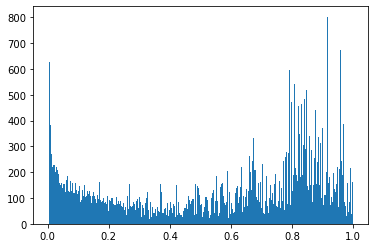

In [42]:
sample_arr = arr_sorted[sample]

_ = plt.hist(probability_arr[sample_arr[:,0][:num], sample_arr[:,1][:num]], bins=300)

In [ ]:
for count, prediction in enumerate(arr_sorted[sample]):
    print(prediction)
    ligand_idx = prediction[0]
    target_idx = prediction[1]
    probability = probability_arr[ligand_idx][target_idx]
    
    try:
        if not pcv.has_ligand(ligand_idx):
            pcv.create_ligand(ligand_idx)
        
        if not pcv.has_target(target_idx):
            pcv.create_target(target_idx)
        
        if not pcv.has_prediction(ligand_idx, target_idx):
            pcv.create_prediction(ligand_idx, target_idx, probability)
        
    except KeyboardInterrupt:
        raise
    except Exception:
        pass
    
    if count>0 and count%50==0:
        pcv.save_checkpoint()

[160993     79]
[222898    138]
[282541    166]
[124436    112]
[329494     80]
[217403    166]
[124853     64]
[59797   165]
[66325    36]
[61895    52]
[256776    149]
[139052    166]
[119480    123]
[136030     91]
[254744     73]
[76887   170]
[20279   127]
[103424     52]
[250471    138]
[297563     91]
[67349   164]
[271335    116]
[292568    177]
[90983   144]
[258629     79]
[110862    177]
[1828    6]
[14787    33]
[35775   170]
[120106    146]
[232769     11]
[46110   109]
[104334    149]
[2185   88]
[68489    79]
[15417    73]
[127557    102]
[177910    208]
[277245    127]
[313916    171]
[225400    177]
[72994   214]
[156748    108]
[162909     52]
[320779    166]
[150545     76]
[315225     89]
[38825   170]
[273226     84]
[282874    136]
[256766    138]
[10720   166]
[327470    205]
[320918    180]
[39496    76]
[298116    105]
[90393    82]
[222007     88]
[316696     67]
[131588    142]
[222070    136]
[130797    166]
[150059    127]
[308056    162]
[318723      0]
[3

[214834    123]
[188792    149]
[146813     82]
[146411    214]
[197038    215]
[89896    90]
[217620    127]
[132373    127]
[239986    138]
[237625    166]
[215231     52]
[189249    132]
[107465    127]
[312587     84]
[333910    215]
[225123    177]
[67617   149]
[162636    149]
[72800   202]
[66584   142]
[145616    100]
[292147    162]
[121413     76]
[267372     76]
[67489   133]
[320606     90]
[160626     14]
[162907     52]
[89589   144]
[312630     52]
[173522    162]
[67756   224]
[242382     79]
[52311    94]
[153977    131]
[180917    237]
[337893     91]
[173803    233]
[68378   138]
[281966     99]
[133936    165]
[24062   177]
[276435    138]
[318949     15]
[287170     95]
[111480    177]
[185597    149]
[216712     83]
[331624     76]
[68181    75]
[320568     86]
[68886   177]
[216395     11]
[311031    177]
[69489   166]
[68335    79]
[28065   165]
[71696    90]
[56657   165]
[80146    84]
[65822   165]
[68780   177]
[91829    90]
[44529    95]
[48071    63]
[31104

[191165     11]
[314181    103]
[265391     48]
[217266     52]
[161157     31]
[57254    76]
[168340    177]
[10051    64]
[142735     86]
[42522   154]
[164342     52]
[76682   169]
[89896    71]
[227634    142]
[68544   138]
[269415    149]
[225074    169]
[76744    63]
[294628     88]
[331595     94]
[176113    175]
[58003   140]
[55585   165]
[63912   122]
[160543     52]
[99394   139]
[85996    86]
[279666    142]
[224592    165]
[275340    165]
[134219    139]
[225488     64]
[279925     52]
[110030    220]
[65886   199]
[160186     41]
[333696     94]
[52499   126]
[245271     99]
[26689   170]
[5386  222]
[157763    129]
[312432     71]
[32975   225]
[219391     71]
[234909     76]
[67253   215]
[228369    205]
[74620   118]
[250259    191]
[215789    138]
[77206    52]
[52184   230]
[65675   178]
[300071    122]
[58883   128]
[194546    120]
[254052     94]
[194570    138]
[292446     94]
[67021   103]
[81523    46]
[310061     52]
[25002   127]
[139473    127]
[293405    170

[29359    38]
[209194    138]
[310550     75]
[288342    132]
[62311    52]
[124749     79]
[131407     52]
[103409    127]
[45197   231]
[323920     90]
[66029   224]
[264747     86]
[43483    62]
[154195     90]
[128405    218]
[189945    214]
[127691    138]
[114946    103]
[293826    122]
[153740    127]
[271713    116]
[67814    36]
[314708    139]
[270179    149]
[143671    170]
[305248    166]
[234162    138]
[155370    127]
[331436    102]
[135871    138]
[11877    76]
[218047     99]
[329496    157]
[173278     86]
[68619   120]
[320434    113]
[132705     52]
[66143    73]
[315727     79]
[67617   138]
[180894    237]
[228367     84]
[133123    127]
[130035     72]
[54176    90]
[133124    127]
[280015    166]
[67665   128]
[103430     52]
[165097    164]
[38096    90]
[243037    102]
[153290     52]
[64955   116]
[123275     76]
[215581     52]
[39998   157]
[188797    149]
[66714   178]
[316020    144]
[248078    194]
[328420     38]
[66530   175]
[106029     99]
[76697   1

[171628     75]
[85371    98]
[9080   94]
[324073    155]
[27993   134]
[300232     62]
[217959    149]
[260351    149]
[148523    166]
[90927   104]
[56357    52]
[4355  147]
[20933    80]
[292908    170]
[279869      8]
[65952   120]
[314002     14]
[18844    64]
[211768    228]
[304184     76]
[17750    95]
[328515     88]
[66804   225]
[133127     52]
[335917     82]
[234262    123]
[119418     72]
[270258    178]
[152273    170]
[160538     52]
[82395    86]
[138903      8]
[124790    177]
[281455     14]
[308153     76]
[266252    166]
[48871   164]
[26669    52]
[283170    166]
[49985     0]
[2323  170]
[315150     91]
[16118   170]
[75761    84]
[202320     72]
[163701     76]
[315804    169]
[100223    149]
[38006    64]
[279312     14]
[68718    54]
[137675     95]
[35894   189]
[101886    162]
[272285     82]
[261741     13]
[15998   144]
[285693     35]
[204488    191]
[67594    72]
[9655   64]
[329044    202]
[153742     52]
[15376    70]
[57389   170]
[297930    138]
[114

[111370     32]
[274678    136]
[65964    84]
[234614     79]
[69675    71]
[159605    149]
[68271   224]
[40928    17]
[127567    102]
[171151    175]
[63307   113]
[283745     52]
[69495    32]
[328464     71]
[54305    95]
[73236   215]
[308556     76]
[139704    170]
[222137    119]
[216790     52]
[293514     83]
[71208   180]
[123 191]
[2352  141]
[297256     98]
[28014    31]
[111478    177]
[87183   108]
[318084     10]
[66108   138]
[42852   139]
[39988   138]
[66652   205]
[141659    116]
[68038   205]
[316492     76]
[305625    166]
[278432    132]
[283874    215]
[336937     76]
[324279     84]
[245875    159]
[225066    177]
[67478   222]
[221383     72]
[61267   167]
[312846     76]
[299913    128]
[320406    224]
[66351   138]
[150050    127]
[121890     14]
[56720    76]
[281299    177]
[35391   127]
[84318    57]
[164394    119]
[66305    72]
[89118   215]
[146044    215]
[194526    138]
[160504    194]
[269931    199]
[215218    177]
[178724    215]
[276556    148]
[1

[41871   170]
[110854    177]
[92173   123]
[67914   150]
[178541    158]
[67664   215]
[83349   164]
[4433   90]
[297873     52]
[98256    98]
[68356   224]
[104823    149]
[72567    90]
[274993     91]
[870 177]
[115639    202]
[18253    64]
[145270    127]
[78302   199]
[46156    93]
[155119    166]
[317146     63]
[156516    131]
[337467    170]
[198958    123]
[123748    177]
[305854    170]
[255351    120]
[37045   224]
[233984    116]
[300301    138]
[163826    158]
[200607    178]
[193850     73]
[126222     98]
[159645    222]
[67082   215]
[8957   95]
[157500     83]
[310264    164]
[196807    155]
[123154     76]
[56538    33]
[67605   224]
[93394   165]
[119322    165]
[69410   113]
[292392     98]
[240130    138]
[96100   164]
[49948   122]
[246815     73]
[306192    225]
[152668    116]
[160360    178]
[66418   138]
[26828   170]
[327398    103]
[135992    170]
[260906      6]
[333971     82]
[190775    169]
[109882    149]
[131407    127]
[66171   142]
[185615    149]
[1

[294051     76]
[14595    19]
[124256     83]
[214210     95]
[84381   149]
[83019   139]
[66896   191]
[160716     52]
[307452     95]
[101608     52]
[237995     86]
[114053    116]
[202319     72]
[90148   149]
[270121    138]
[277040     64]
[238912    131]
[115351     80]
[14033   224]
[25257   162]
[211840    233]
[156338     76]
[295204    170]
[256198    183]
[223907    177]
[278830     72]
[140605     52]
[117391    100]
[97834    52]
[148499     11]
[265840    218]
[226554    142]
[94926   134]
[117217     98]
[120479     76]
[275130    166]
[289250    178]
[118829    205]
[144572     14]
[209182    178]
[191386    191]
[292161    116]
[283954    127]
[111482    177]
[308345    145]
[279737     73]
[324358    169]
[262637    138]
[327860    103]
[117369    122]
[276420     52]
[308595     75]
[188487    149]
[165567     52]
[82161    84]
[51956    86]
[294902    169]
[183515    166]
[14332    98]
[217807    165]
[245658    214]
[68046   224]
[200354     14]
[142583    123]
[6

[280156    225]
[92119    75]
[36778    18]
[148285     84]
[20414   116]
[260953     88]
[315397    177]
[145643     76]
[6164   88]
[138422     83]
[94540   116]
[5792  192]
[40506   136]
[255908     76]
[225606    204]
[217908    127]
[262631     72]
[136783     98]
[185611    149]
[278088    139]
[36792    86]
[311049    138]
[147901    127]
[111439     76]
[329424     16]
[321021     70]
[66663    36]
[314938    116]
[79443   138]
[230452    123]
[68365   100]
[48591    14]
[239571    215]
[140613     52]
[46782    99]
[311329     82]
[66262   183]
[216259     52]
[166211     30]
[96098    73]
[122522     63]
[201737    199]
[320130     67]
[66513   183]
[54518   160]
[256670     36]
[63420    94]
[56392    52]
[309543     67]
[99591   165]
[108053     84]
[188496    149]
[220518    218]
[120570     71]
[252011     72]
[103728    214]
[223185    178]
[118642    166]
[66982   202]
[183266    233]
[3440  142]
[336180    102]
[49782   169]
[245492    214]
[155625    142]
[209193    1

[47408    93]
[226206    215]
[305341     72]
[157699     83]
[68616   131]
[60494   172]
[320348     90]
[90477    94]
[105330     88]
[49784   169]
[17963   171]
[319826    103]
[326668      9]
[273944    136]
[277447     88]
[82919    88]
[66021    24]
[155366    127]
[328956    170]
[188805    149]
[48303   138]
[129655    194]
[224196    170]
[176489    199]
[173029    136]
[70866   140]
[151137    149]
[66748   149]
[319883    128]
[142968    127]
[15443    90]
[171155     29]
[171143     36]
[159503    177]
[280239    225]
[167080    121]
[16236   215]
[66020   202]
[113556     16]
[99122   165]
[1701  102]
[41088   122]
[22914   191]
[219246     88]
[1251   70]
[76689   141]
[24690    83]
[126960     84]
[278760      0]
[187650    138]
[45370   170]
[43388   177]
[333176    127]
[205030    100]
[188592    214]
[68093    13]
[67064   224]
[210039      0]
[125255    138]
[92477    13]
[35067   170]
[115608    178]
[217399    171]
[6431   48]
[309888     84]
[79908   122]
[71217  

[703  25]
[309663    103]
[68214   150]
[67496    29]
[126975     42]
[254755     14]
[209169    136]
[22613   194]
[92767    71]
[169694     51]
[185608    149]
[104814    149]
[122918    127]
[295848    127]
[67192   199]
[5547  178]
[156304     70]
[67069    36]
[222357    126]
[49386    11]
[132706    127]
[61059    99]
[161049    194]
[246242     72]
[178185    161]
[37391    46]
[157542    162]
[10436   127]
[97861   171]
[79805    52]
[66317    79]
[104489    141]
[240588    237]
[176515    178]
[74322   118]
[152669     18]
[37958    52]
[5456  103]
[19700    18]
[61973    57]
[248506    194]
[11189   138]
[253475    215]
[65228   127]
[79384    90]
[295971    170]
[67124    48]
[156575    127]
[279754    138]
[69408    35]
[209806    150]
[169325    191]
[190691     79]
[154547    225]
[83815   133]
[163240      8]
[105719     84]
[160711     52]
[14967    84]
[320335      6]
[81231    84]
[194529    138]
[140172     82]
[257501    158]
[133120     52]
[76133    64]
[85218   1

[93572   139]
[209193    138]
[133123     52]
[303138    123]
[155875    170]
[87913    37]
[240422     73]
[73427    98]
[265186    233]
[82122   164]
[194573    236]
[278384    178]
[177798     73]
[314054     84]
[110853     52]
[233868    154]
[217115    116]
[221040    138]
[78822   194]
[332298     91]
[57674   165]
[190657    205]
[175195    138]
[335429     82]
[98301   164]
[118157    100]
[154321    138]
[253189    199]
[332183     94]
[118185     67]
[66468   136]
[95516   231]
[107452    165]
[38249   116]
[104998    149]
[190142    214]
[65630   154]
[9839   94]
[60348    48]
[329966    162]
[16997    48]
[271115    178]
[79000   116]
[107315    165]
[54766   142]
[147584    177]
[166529     36]
[56378    82]
[67618    11]
[264947    199]
[194538    138]
[227313    196]
[68918   113]
[68371   142]
[61203   144]
[286808    214]
[93100   116]
[135380    116]
[58232   215]
[66368   185]
[60062   125]
[116847    122]
[291227    170]
[117587     99]
[107504    166]
[117541    1

[98983   127]
[54401   162]
[40065   224]
[197367    188]
[152115    214]
[50034   237]
[91913   149]
[263420    136]
[65998   131]
[296534      8]
[66094    31]
[140581     17]
[275449    102]
[262593    102]
[2674  102]
[68000   149]
[194496    138]
[134503    100]
[225367    177]
[292549    170]
[173266    132]
[184753     13]
[67448   237]
[194579    191]
[158956      6]
[15180    71]
[169161    116]
[320401     90]
[297494     84]
[303419    136]
[259511    237]
[239398     32]
[72030    98]
[140332     94]
[68422   199]
[295292    155]
[212166    165]
[221321     76]
[161698     74]
[84381   142]
[40535   177]
[169335    180]
[83188   167]
[281221    127]
[257278    233]
[63895    90]
[74193   139]
[295618    177]
[105720     76]
[278802     52]
[119951     78]
[148282     84]
[38470    95]
[109956     90]
[311057     82]
[313311     90]
[133136     52]
[107549     52]
[299805    103]
[11292    13]
[121659    105]
[286542    132]
[154737    127]
[234798     84]
[105733    165]
[3

[53427    31]
[215059    224]
[159782    185]
[309176     72]
[63811    91]
[192073    192]
[191382    138]
[166939     79]
[214903    180]
[97834   127]
[120550     98]
[139884    139]
[65230    52]
[77929   224]
[131244    170]
[267013    166]
[42517   170]
[213334     78]
[215965     86]
[307893     72]
[297015     53]
[230095     84]
[143127    162]
[170079    159]
[291135     88]
[58267   194]
[13376    33]
[176212    233]
[311271    224]
[248891    204]
[136698    102]
[313468     18]
[164343    127]
[148 128]
[67160   214]
[67448    73]
[163415    127]
[66080   224]
[28828   108]
[3914  149]
[291975    177]
[40670   171]
[66675   164]
[65231    52]
[310721     95]
[57586   165]
[191376    191]
[222258    158]
[67570   123]
[252474    199]
[320394     90]
[44629   121]
[335303    139]
[319624    169]
[75044    72]
[1008  128]
[27987   160]
[37858   158]
[334862    146]
[233592    127]
[95890    52]
[295095     70]
[65223   127]
[315340     64]
[67174   142]
[57369   222]
[77210  

[255747    138]
[129414    177]
[65980   205]
[325814     88]
[12678    62]
[97990   131]
[178084    214]
[9905   90]
[75901    71]
[121091    100]
[252848     76]
[116594     72]
[55530   147]
[156574    127]
[137390      6]
[225389    177]
[287387     88]
[135186    116]
[173559    149]
[311049    180]
[60296   194]
[109907    123]
[16619    16]
[316330    111]
[143725     98]
[272659    141]
[194542    138]
[92173    89]
[272892    123]
[117189    116]
[279635    165]
[251288     14]
[261206    224]
[48540   122]
[235993     49]
[142974    127]
[44803   172]
[68070   205]
[69159    13]
[160606     14]
[301473     68]
[247934     52]
[127241    139]
[223822     48]
[117621     53]
[156570    127]
[37773    90]
[167583     13]
[2515   88]
[273309     14]
[96654    95]
[320011     76]
[67551   149]
[136604     34]
[331724     29]
[332678    220]
[124510     91]
[33547    76]
[275101     56]
[57739   165]
[219824    138]
[324369     84]
[323156     84]
[132569    127]
[260543    138]
[1

[29026   104]
[282914    136]
[32002    98]
[250617    149]
[275863    177]
[32628   225]
[284381    148]
[132702    127]
[66815   131]
[127881     13]
[133135     52]
[187259    176]
[197332    199]
[194541    191]
[21335   157]
[73020    73]
[46773   126]
[307648    164]
[295992    139]
[142714     71]
[99183    52]
[52670   214]
[332091     86]
[281992    149]
[119618     84]
[3267   36]
[261117     73]
[67618   215]
[83914    52]
[158586    169]
[62780   136]
[302193     88]
[256192     79]
[144574     14]
[194009    150]
[129526    177]
[165108    105]
[4534   31]
[108590     14]
[81176    95]
[322804     90]
[133643     48]
[175114    138]
[286846     86]
[66982   191]
[101627     84]
[21424    76]
[194578    138]
[182925    133]
[246501     72]
[270590    189]
[78566   126]
[273226     71]
[30955    95]
[116584    192]
[306518    161]
[128511     98]
[320341     90]
[99593   127]
[79830    83]
[41698   178]
[2656  175]
[67970   150]
[36585   149]
[178157    144]
[330871     90]


[29448    40]
[322756    138]
[63228    91]
[309630     82]
[194304    167]
[243296     46]
[85353    98]
[225593     76]
[336075    138]
[297218    170]
[66273    38]
[263754    120]
[332739    179]
[316729     86]
[68200    88]
[294641    224]
[144569     14]
[145158     82]
[204465    191]
[236491    237]
[36284    71]
[194514    191]
[49591   169]
[65952   150]
[140612    127]
[321063      9]
[15947   159]
[180962    237]
[305639    215]
[133121     52]
[58487   233]
[2480   36]
[314443    174]
[313802    138]
[130466    170]
[223667    103]
[14489    76]
[187554    228]
[242867    169]
[160963     71]
[295938    150]
[331535    170]
[117580    224]
[167498    100]
[275670    161]
[232946    105]
[263801    180]
[133135    127]
[100534    161]
[301515     94]
[49514   116]
[264480    142]
[286144     79]
[164122     34]
[95978   224]
[322559    128]
[262264     48]
[316291     76]
[113238     11]
[73148   123]
[322559    164]
[141631     95]
[70153    88]
[11021   160]
[75482   144

[126764    112]
[140896    170]
[3979  169]
[178062     40]
[125453     83]
[199986    164]
[153505    177]
[158566    136]
[78314    64]
[33330   134]
[252315    155]
[265279     98]
[9170   83]
[330679      9]
[123233    141]
[126939    169]
[67806   215]
[312151    222]
[106980     54]
[36591   149]
[90128   149]
[161184    194]
[39436   122]
[276711    177]
[93034    62]
[332975    170]
[258475     73]
[178238    161]
[242676    138]
[312008    215]
[210567     73]
[336446    170]
[175918    159]
[46237   108]
[75341   164]
[46837   103]
[66470   149]
[270951    191]
[108301     36]
[295243    136]
[299604    104]
[315965     70]
[239381    233]
[325691     72]
[157500     91]
[323298     86]
[76210    79]
[194553    191]
[217635    127]
[116684    165]
[3092  188]
[188461    149]
[206153     98]
[66020    13]
[71869    31]
[142759    139]
[10778    90]
[91971   116]
[67798    79]
[73144    90]
[148196    222]
[77530   202]
[157382    103]
[226469    127]
[89011   116]
[9479  136]


[320652     98]
[254388     36]
[51404    82]
[59899    27]
[287798    224]
[36782    84]
[647  67]
[269218    222]
[265989    191]
[160124    108]
[237445    166]
[67998   149]
[100320    141]
[170111    159]
[150320    166]
[146822     82]
[300611     67]
[314904    224]
[136728     93]
[122911     88]
[147942    127]
[32315   165]
[103845    167]
[188164    108]
[29431    83]
[51291   139]
[315761    162]
[214813     15]
[102020     14]
[117022     76]
[133128     52]
[334144    102]
[165910    165]
[10428   170]
[94294    95]
[282077    149]
[72991    79]
[227428     13]
[82122    36]
[40002   218]
[226191    127]
[84186    90]
[256670    138]
[115079    165]
[103530    220]
[66535    29]
[74407   127]
[227983    228]
[217342    102]
[144383     54]
[152308     31]
[19344    95]
[192991    131]
[203606    149]
[68981   128]
[290780    215]
[275227     52]
[238897    233]
[67146    88]
[66440   142]
[72870    95]
[94488    71]
[150543     76]
[68473   224]
[280259    116]
[261809   

[60426    48]
[185601    149]
[11027   122]
[62836   138]
[37886   159]
[279309     98]
[107329    166]
[134790     76]
[45557    84]
[66451   224]
[311590    194]
[280277    194]
[283701    136]
[99699   165]
[125258     83]
[37957   177]
[12488   139]
[203490    194]
[271223     90]
[6485  158]
[72164    82]
[75663    71]
[94262   104]
[279863     90]
[243535    199]
[325845     81]
[107154    149]
[164638     71]
[209186    178]
[336075     11]
[15416   154]
[316905    141]
[275815    166]
[1782   98]
[64009    15]
[253403    222]
[156520     13]
[163689     86]
[280710    138]
[301552     94]
[274660    158]
[67584   215]
[191381    138]
[190906     73]
[277198    225]
[150609     71]
[84305   212]
[228122     16]
[272444    116]
[123266    116]
[127656     90]
[93672   205]
[159514    177]
[129403     17]
[106892     11]
[88145   123]
[249108    191]
[329928    162]
[152111     48]
[153682     76]
[81733     9]
[67454   142]
[159431     93]
[45409    83]
[42928    67]
[300519    2

[12647    98]
[322079    128]
[116686    103]
[207911    149]
[87546   129]
[76409   138]
[146045    215]
[308138     72]
[200266    158]
[281043    191]
[280375    127]
[12252   138]
[337539    177]
[310963    170]
[310634     72]
[327632    178]
[307287    192]
[295597    224]
[131876     73]
[123465     75]
[310923    121]
[83336   138]
[217060    127]
[200894     40]
[133843    102]
[297173     38]
[75374   140]
[27897   225]
[333112    123]
[173842    233]
[15255   138]
[263900    224]
[329496    236]
[227195    141]
[260275    169]
[272913    179]
[67452   202]
[286264     73]
[68021   138]
[316871    141]
[130473    127]
[68145   215]
[204478     79]
[220916    122]
[224807     29]
[318496    149]
[230588     98]
[263801    175]
[324366    215]
[109950    103]
[272657    116]
[202984     70]
[114467    220]
[43196   108]
[262403     90]
[290507    183]
[103090    175]
[173061    128]
[56497   198]
[192133     48]
[152406     52]
[281465    149]
[234729    149]
[275602    103]
[9

[50436    79]
[306660     49]
[68468   136]
[334862     98]
[78810   194]
[85997    76]
[314213     81]
[160715    127]
[66483   140]
[217341     94]
[153743    127]
[2556   16]
[147161     13]
[61873   138]
[185919     36]
[2757   62]
[294629    122]
[321722    128]
[319592    215]
[337744     76]
[10184    22]
[330228    224]
[117988     88]
[24042    54]
[142712     38]
[66873    73]
[228327    136]
[306563    122]
[222204    178]
[41634   127]
[68545    75]
[279914      9]
[111473    177]
[139115    112]
[103614    129]
[99081    95]
[107327      8]
[59825   165]
[282874    138]
[273378    139]
[120461     89]
[45429    83]
[989  94]
[40003   138]
[98102   165]
[187418    167]
[67947   150]
[311723     32]
[68616    48]
[38463   142]
[88118    84]
[323264     82]
[55118   178]
[15856   170]
[155917      8]
[3644  214]
[224642     48]
[235885    198]
[167821    164]
[154776    177]
[300746    105]
[68343   116]
[308276     83]
[322980    138]
[305761     98]
[310566     88]
[255025 

[92464   170]
[170758    133]
[51867   100]
[66542   175]
[183502     32]
[116696    116]
[86907   214]
[67988    95]
[68571   205]
[177141    165]
[314025     84]
[36267    76]
[269068    123]
[132043    127]
[173523    139]
[107124    116]
[16497   169]
[129288    141]
[90407    79]
[135561     54]
[76685   141]
[45035   204]
[66866   161]
[119039    102]
[20634   218]
[74114    64]
[1450  160]
[61657   192]
[119596    100]
[152030    175]
[82693    73]
[176518    178]
[157319    170]
[277504      8]
[14386   113]
[225172    141]
[160618    161]
[57883   128]
[51150    14]
[66604   150]
[307954    103]
[277363    162]
[62235   170]
[325413    119]
[2158   62]
[319131     88]
[107464    127]
[332325     53]
[92424    99]
[85856   214]
[70826    76]
[134013    165]
[92929    94]
[246848    134]
[40682    68]
[110848    127]
[242063     73]
[105043    149]
[109894     89]
[67289   150]
[226772    119]
[279425    166]
[68534   215]
[117183     36]
[275076    105]
[15613   139]
[85562   1

[87493    98]
[281616    100]
[211761    228]
[17495    84]
[36234    98]
[120365     36]
[3984  169]
[16603   170]
[320706    136]
[67609   215]
[66801   154]
[295640    136]
[123454    178]
[63572   177]
[68468   215]
[171137    149]
[332386     30]
[239083    102]
[220216     80]
[268385    205]
[138336     71]
[66880   155]
[277662    162]
[301488     88]
[321588    127]
[156209    166]
[67057   150]
[148481     36]
[300622     90]
[10566   224]
[156578     52]
[250400     89]
[112641    215]
[44989   128]
[73924   122]
[219977    192]
[72797   131]
[148060     86]
[221815    178]
[110323     28]
[85384   194]
[40825    76]
[176093    138]
[109204    149]
[73498   104]
[3275   99]
[299202     70]
[160024     18]
[76608   194]
[243917    233]
[151031    149]
[331503    165]
[207904     73]
[230491    166]
[125377     83]
[175397     36]
[252116    149]
[308945    169]
[120433     46]
[96132   158]
[250636     11]
[333538     52]
[200922    178]
[281476    122]
[207324     14]
[74125

[66128   120]
[313089    155]
[160360     73]
[107320     14]
[10428   179]
[303420     79]
[241026    123]
[306849     38]
[294218     75]
[274462     95]
[304260    133]
[259326    194]
[56130     6]
[161001     79]
[4475   41]
[168960    154]
[210561     73]
[29515    72]
[301730     88]
[1044   98]
[133785    194]
[33324   225]
[120516     38]
[12311   138]
[328903    158]
[66849   136]
[26637   112]
[162684     29]
[167733    164]
[331382     94]
[62935    81]
[301230     87]
[273001    158]
[261608     68]
[69700    98]
[45419    86]
[317567     67]
[310602    104]
[287598    128]
[194556    191]
[156583    196]
[240942     80]
[66884    75]
[67720   162]
[67897   202]
[78868   121]
[337512    170]
[42321   225]
[160602     14]
[205257    138]
[249567    194]
[109529    165]
[312063     11]
[141366     18]
[330758    127]
[103685    163]
[222663     75]
[89013    53]
[90152   149]
[135379     38]
[263123    102]
[39887   149]
[276225    103]
[259282     14]
[116079     82]
[66155

[217544    165]
[206589     15]
[202084    154]
[283456     73]
[237357    225]
[45013   180]
[16978    48]
[30006   162]
[196413    215]
[79059   127]
[150541     76]
[173265    185]
[188804    149]
[223697     86]
[117626     50]
[58254   194]
[174170    228]
[41761   198]
[126931     70]
[215739     99]
[269355    123]
[230744    158]
[252570     40]
[322482    138]
[250396     48]
[130586    194]
[184518    149]
[68534   214]
[67814   123]
[74265   129]
[327546     98]
[155424      6]
[80089   154]
[67538   218]
[131586    175]
[213126    193]
[67591   154]
[32490   139]
[309248     67]
[299412    130]
[67871   165]
[68021    89]
[86367    90]
[107460    127]
[80582    99]
[242224    224]
[14969    71]
[130652    199]
[26224   170]
[333280    220]
[328829     91]
[23164   225]
[68296   138]
[248237     79]
[136320    165]
[193960    178]
[192071    104]
[123304    176]
[231647    237]
[28237   177]
[70228   230]
[133309     70]
[308605     72]
[198439     72]
[94864    99]
[262351 

[66110   236]
[151816    105]
[146048    215]
[178313     16]
[66162   140]
[311308    103]
[241040     32]
[333179    214]
[222227     98]
[301386    199]
[308811    178]
[26450   165]
[275301     59]
[324402     48]
[322257    127]
[29646   139]
[106353    100]
[73668    64]
[66021   120]
[35880    16]
[162711    170]
[139336    138]
[66513   149]
[301956    177]
[160848     30]
[73346   105]
[34308   127]
[329406    122]
[66325    16]
[36266    76]
[284344     31]
[124459     91]
[329797     95]
[146146      9]
[159928     33]
[246517    180]
[289976    215]
[263052    144]
[220131     57]
[66970    13]
[278648    136]
[191380    191]
[14857   176]
[127094    170]
[98528   180]
[2825  237]
[3782   84]
[275648     71]
[246820      6]
[214460     34]
[15648   165]
[311049     36]
[190902    142]
[192986    154]
[244802     48]
[65982    90]
[332296    141]
[176295    178]
[133136    127]
[322139    150]
[298329    160]
[142627      9]
[277482    177]
[193228    170]
[334350    134]
[1

[316726    236]
[18804   170]
[131596    149]
[167772    178]
[226586    185]
[6250  158]
[68367   138]
[336351     76]
[24890   165]
[63985   167]
[72981    90]
[194528    138]
[30090   225]
[266359    168]
[232026     84]
[305931     19]
[172238    167]
[59172    56]
[147588    154]
[12480    71]
[13730    71]
[260918     29]
[62074   113]
[275231    112]
[116876    101]
[289208    154]
[206855     80]
[221904    116]
[172524     76]
[68514   215]
[327816    150]
[136589    103]
[286393    149]
[141974     29]
[156568    127]
[5440  127]
[223394    161]
[183963     80]
[145257    127]
[8604  209]
[52269    70]
[291638     82]
[264605    233]
[126899    140]
[238809     14]
[21199    73]
[330047     93]
[258775     76]
[278728    199]
[57289    76]
[287668     36]
[1858   99]
[172132    144]
[145652     76]
[13056   177]
[20768   123]
[67372   180]
[139452     11]
[296433    220]
[45424    83]
[87086   166]
[240464    149]
[287283     36]
[67780   136]
[44677    88]
[187359    159]
[2

[285997    123]
[104816    149]
[331178    102]
[116483     94]
[68116   141]
[336342    162]
[103721     11]
[19167    98]
[241998    138]
[326999    103]
[184133    215]
[278603     56]
[261815    133]
[247232    128]
[253721     76]
[110003    191]
[67085    11]
[305884     84]
[190795    162]
[319697     20]
[66982   183]
[178290     36]
[183148    233]
[166320     98]
[243225    237]
[211515     31]
[158571    111]
[50880   158]
[127887    136]
[255713    149]
[158210    177]
[300346     31]
[337470    170]
[8361    8]
[58252   158]
[273226     98]
[324813     76]
[264742    138]
[56853   154]
[82265   172]
[292220    162]
[90595   123]
[21200   204]
[92789    95]
[271575    179]
[281026    116]
[90122    75]
[279003    162]
[265271    102]
[94125    16]
[256103     27]
[114317    166]
[145707     82]
[132656    194]
[116257     76]
[58213    75]
[211966    125]
[213189    147]
[250984     72]
[226968      9]
[284835    214]
[173763    233]
[304324    103]
[66765   205]
[274983   

[202809    205]
[327151      9]
[143274    131]
[307880     98]
[158872    127]
[227924    205]
[100912    113]
[285435     13]
[136572    177]
[32884   166]
[215042     99]
[115316    161]
[317326     86]
[77208   165]
[305254    166]
[140287    198]
[90738   165]
[67688    36]
[222582     91]
[98155    84]
[99750   155]
[234156     73]
[67152    31]
[329228    100]
[251722    138]
[110238     91]
[150684    170]
[22576   225]
[80724   116]
[333109     76]
[114557     82]
[11994   141]
[111975    103]
[54768   142]
[98278   214]
[48629   191]
[37693    84]
[134045    177]
[100849    131]
[10281    52]
[63389    91]
[185775    165]
[261136     89]
[278451     98]
[68038   191]
[261500     90]
[337400    189]
[219920    126]
[11470   149]
[125097     95]
[45033   138]
[324170     95]
[72164    90]
[198041     89]
[111667    131]
[326011    127]
[167167    149]
[332126     71]
[20126   149]
[7379  166]
[314387     14]
[127893    138]
[100389    104]
[67698   164]
[33016   100]
[273310   

[23310    54]
[76210   142]
[281508    132]
[324668    162]
[62336   123]
[205555    197]
[133290    224]
[287922    214]
[51703   127]
[200604    138]
[298214    169]
[67950   202]
[20773   122]
[94324   178]
[81571   116]
[169526     91]
[67241   224]
[164932     14]
[300811    166]
[295699     83]
[144523    116]
[321517    142]
[23062    38]
[117333     88]
[113787    148]
[88138   150]
[294083     13]
[221367     76]
[8955  131]
[66348   215]
[304975    212]
[253430    183]
[203978    198]
[59820   239]
[333036    141]
[74408    52]
[80976    31]
[300172     76]
[295533     22]
[333750    170]
[254463    193]
[271127      6]
[226923    127]
[14369   113]
[222291    138]
[184511    199]
[332552      6]
[107421     95]
[121520     51]
[190799    162]
[336477     38]
[273704    103]
[327369     90]
[172955     31]
[56310    33]
[335403    162]
[298547    170]
[71518    68]
[126023    196]
[205545    104]
[60946   165]
[117581     99]
[31904    70]
[273198     11]
[98595   166]
[14277

[272323    116]
[62685    17]
[75756    84]
[157623     76]
[69524    79]
[98294   194]
[66701    31]
[220650     98]
[227358    136]
[166540    103]
[210868    222]
[126941      9]
[97820    84]
[274185     94]
[307001    121]
[16900    91]
[266048    155]
[143619    177]
[101475     52]
[258270    158]
[67152    36]
[222135    138]
[55902   178]
[126877    139]
[20110   203]
[221179    138]
[106624     88]
[136513    146]
[36319    71]
[111509    102]
[115896    121]
[222337     64]
[145161     86]
[212108     62]
[46142    98]
[48281    76]
[99090    82]
[123167     83]
[68403   123]
[322893     25]
[262382    199]
[64095    33]
[266239     76]
[104879    129]
[333858     76]
[169145    233]
[331000     48]
[304506    144]
[33737    15]
[23510   154]
[300809    142]
[116357    138]
[113926    185]
[230330    158]
[115252     32]
[127473    102]
[259558    169]
[139467    177]
[81072     9]
[249332    161]
[237625     14]
[61100   170]
[27753    98]
[75186   116]
[187586     89]
[685

[94763   160]
[113187    149]
[213597     76]
[7997  158]
[309114    180]
[113348     13]
[19749   220]
[68004   215]
[39426   122]
[42738   225]
[291639     90]
[43913   119]
[219247     90]
[4965  224]
[214504    102]
[149808    222]
[293760     84]
[26413   177]
[301817     95]
[299757     82]
[74099    68]
[267355    136]
[5662  120]
[250794    138]
[327652     86]
[56568    29]
[294030    104]
[103944      8]
[284743    224]
[229052    183]
[2315  205]
[122797     63]
[42638   170]
[141382      0]
[277458    138]
[75062   165]
[36536   159]
[72453   225]
[63663   102]
[319459     52]
[68566    36]
[314685    147]
[250197    214]
[19868    46]
[31702    71]
[307489    214]
[12888   177]
[66214   154]
[146784     84]
[231353    178]
[214648     48]
[29909    71]
[78272   193]
[94491    80]
[323475    142]
[325713     76]
[82112    98]
[249994    194]
[48802    94]
[68619   154]
[160145     95]
[329741    172]
[304000    119]
[99191    50]
[149397     78]
[233858    138]
[115130     

[276401     36]
[331499     94]
[67859   136]
[255385    149]
[327719     98]
[309757      6]
[324492     36]
[308179    149]
[73034    99]
[191367    191]
[89762    76]
[282114    191]
[142695    105]
[302214    194]
[257431    102]
[275054    121]
[40790   222]
[238279    180]
[303591    109]
[238264     84]
[68657    31]
[334154    122]
[303045    198]
[21130    84]
[143447    237]
[230810     78]
[36885   179]
[43692    13]
[16192   140]
[216581    194]
[283186    166]
[143884     86]
[106843    205]
[78331    31]
[173853    233]
[28943   162]
[61218   167]
[283551    158]
[101477    127]
[126901    150]
[16237   215]
[68489   128]
[37865   158]
[66552   164]
[303613    142]
[67780   150]
[159936     33]
[123721    180]
[19878   178]
[242750     35]
[111596     75]
[107070    105]
[321134    160]
[289772    175]
[66802   175]
[146389    164]
[263102     31]
[84758   128]
[275274     94]
[163684     84]
[19741    84]
[13374    33]
[67675   204]
[127697    103]
[259048    191]
[29821

[117653    218]
[159211    170]
[160318    144]
[40521   169]
[154327    165]
[1920   98]
[155644     14]
[181244     11]
[173382    215]
[264034    199]
[67775    31]
[109217    142]
[244343    149]
[160119    108]
[15742   105]
[319044    141]
[11425    29]
[171473    155]
[130729    119]
[66982   237]
[266616    225]
[298608     94]
[94899    80]
[158708    177]
[41510    53]
[12175   192]
[42877   170]
[100862     99]
[211708    194]
[161053    167]
[223785     48]
[43294    91]
[252045     78]
[289522    140]
[171170    158]
[305617     88]
[10532   172]
[317048     73]
[49636   165]
[63015   136]
[265285    237]
[57782    98]
[220504    177]
[96572    14]
[256785    102]
[66077   215]
[126473     94]
[288756    103]
[68213    16]
[294414     67]
[312011     95]
[214171    100]
[299055    194]
[333034    170]
[297714     64]
[171180    158]
[80344    82]
[157016     18]
[242175    133]
[225098    161]
[169400    142]
[1193  169]
[123082    116]
[121443    149]
[283972      8]
[138

[184116    142]
[65998   150]
[176347    123]
[141956     14]
[190755     79]
[311320    103]
[293747     88]
[233291    150]
[312303     86]
[307358    225]
[335125     76]
[276729      8]
[84197   102]
[125290     83]
[106304     84]
[192843    125]
[157338     76]
[276761     84]
[ 44 198]
[21371    51]
[327747     80]
[29932    70]
[294389      9]
[156766    108]
[251742    215]
[9157   76]
[333131    138]
[130510    162]
[16427   116]
[66982   175]
[199828     73]
[248513     13]
[56244   178]
[68349   214]
[311492     64]
[23369    84]
[326236    122]
[205201      9]
[10566   199]
[179305     73]
[27181   166]
[217336    161]
[33646    95]
[221554    178]
[68012   136]
[223380     95]
[55830    98]
[180585    208]
[120663    103]
[171392    142]
[67814   149]
[137723     81]
[68035   140]
[124062    147]
[26479   225]
[291494      9]
[180966    237]
[139657     98]
[28280    84]
[227053    224]
[49234   166]
[51906   100]
[134225    139]
[68593    11]
[63387   113]
[7813  121]
[2

[15410   177]
[313626    214]
[65940   123]
[238878    131]
[276041     84]
[250487    175]
[279957    165]
[300625    103]
[224520     86]
[72650    78]
[129949    170]
[93961   119]
[68562    89]
[102995    138]
[67340   128]
[118891     99]
[137429    147]
[100977     78]
[5222  123]
[68445   150]
[319291     67]
[103402    215]
[246325     54]
[193010    138]
[49234     8]
[333724    170]
[68616   129]
[68096   105]
[108811     90]
[219199    108]
[279368    147]
[246469     11]
[311503    119]
[66171   128]
[128746    235]
[281881    194]
[15417   155]
[224233     80]
[334302     76]
[267583    149]
[15807   138]
[56130   178]
[312032    103]
[264073     79]
[98731    82]
[121020     70]
[207615    100]
[7949  131]
[160562    177]
[148641    100]
[135935    162]
[73893   122]
[266225    138]
[295311    177]
[216517     99]
[67605   128]
[103015    138]
[336936     76]
[190623    138]
[85379   132]
[89626   165]
[44427     0]
[165638     76]
[284095     14]
[8100    8]
[136773     

[148452    119]
[249289    119]
[234324     84]
[142707     86]
[280050    133]
[298816    214]
[144117    139]
[154064    116]
[290995     84]
[15543   170]
[232036    161]
[152118    138]
[71099    36]
[66730   104]
[303876      9]
[233187     73]
[306673    233]
[71844    64]
[141096    235]
[332866    170]
[58240   138]
[295598    127]
[67859   154]
[81250   116]
[66663   133]
[70064   237]
[78835   172]
[20243   147]
[213300     98]
[319259     88]
[333150    171]
[175713    154]
[76252   147]
[334431    178]
[292436    177]
[66240    11]
[120545     76]
[319172    218]
[321573     32]
[224106    138]
[326587    170]
[331303    102]
[171401    133]
[145689    177]
[145471    170]
[304550     91]
[174620    194]
[77437   121]
[237524     31]
[75071   165]
[309729    138]
[77518   136]
[110003    199]
[200605    123]
[88640    76]
[150544     76]
[78964    36]
[201751    136]
[114623    139]
[333686    127]
[198061    199]
[67663    99]
[232769    131]
[19790   174]
[317701     98]


[18973   165]
[309857    154]
[211058    137]
[68604   150]
[224723    120]
[305409    185]
[223363    237]
[269362     48]
[272847    123]
[206866    160]
[280676    168]
[67378   215]
[73545   133]
[67341   215]
[292585     71]
[60913   116]
[122789     18]
[110786    224]
[123013     82]
[66873   237]
[53533   122]
[254630    224]
[114922     49]
[133812     76]
[158089    141]
[90952    75]
[160467    141]
[101013    236]
[73695   236]
[177639    131]
[333404    170]
[290029     16]
[263753     11]
[66485   214]
[68440   102]
[20272   183]
[3644   36]
[169366    142]
[321444    142]
[16067   155]
[115485    169]
[64979   122]
[243035    136]
[4327  165]
[279327    159]
[65939   204]
[194519    191]
[102459    127]
[223301    122]
[302197    165]
[225297    141]
[83581   180]
[226387     98]
[100885     79]
[24952    83]
[54316    67]
[279700     83]
[193946     31]
[303507    122]
[82271    99]
[242191     84]
[158806    127]
[91943    67]
[21214   225]
[8481  125]
[64956   116]
[1

[315063    141]
[47311    88]
[331656     95]
[224155    194]
[86693   222]
[37602   218]
[249628     40]
[155107    177]
[36884   162]
[223472     98]
[28872   225]
[183499     14]
[121407    162]
[3306  133]
[2037   14]
[80872   116]
[294335    165]
[67265   136]
[228367     71]
[86622    13]
[312776     15]
[68470   100]
[79438    79]
[302433    103]
[27540   154]
[133785      0]
[278415     48]
[190831    169]
[121968    102]
[92017   116]
[141330     80]
[76552   194]
[315076     84]
[278928    150]
[23677   170]
[129749    150]
[115485    162]
[253842    158]
[123010    171]
[272776     91]
[41704    82]
[35527    98]
[57894   169]
[193850     36]
[312053     30]
[133955    165]
[155927     14]
[67490   164]
[327156    121]
[67065    88]
[72484   108]
[142898     11]
[66110    79]
[130649    183]
[106329     84]
[220510      6]
[211064    230]
[328837     98]
[271180     16]
[124926    178]
[37462   105]
[66873   199]
[67448   136]
[317808    127]
[63472    90]
[274038    165]
[1

# Make sure the top 20,000 are accounted for:


In [ ]:
for count, prediction in enumerate(arr_sorted[np.arange(20000)]):
    print(prediction)
    ligand_idx = prediction[0]
    target_idx = prediction[1]
    probability = probability_arr[ligand_idx][target_idx]
    
    try:
        if not pcv.has_ligand(ligand_idx):
            pcv.create_ligand(ligand_idx)
        
        if not pcv.has_target(target_idx):
            pcv.create_target(target_idx)
        
        if not pcv.has_prediction(ligand_idx, target_idx):
            pcv.create_prediction(ligand_idx, target_idx, probability)
        
    except KeyboardInterrupt:
        raise
    except Exception:
        pass
    
    if count>0 and count%1000==0:
        pcv.save_checkpoint()

# more... more...

In [ ]:
n = 10_000_000
take = 40000

weight = 1 / ((np.arange(n)**1.25)/(0.1*take)+1)
weight = weight/weight.sum()

sample = np.random.choice(n, take, p=weight, replace=False)
sample_arr = arr_sorted[sample]

_ = plt.hist(probability_arr[sample_arr[:,0][:num], sample_arr[:,1][:num]], bins=300)

In [ ]:
for count, prediction in tqdm.tqdm_notebook(enumerate(arr_sorted[sample]), total=take):
    ligand_idx = prediction[0]
    target_idx = prediction[1]
    probability = probability_arr[ligand_idx][target_idx]
    
    try:
        if not pcv.has_ligand(ligand_idx):
            pcv.create_ligand(ligand_idx)
        
        if not pcv.has_target(target_idx):
            pcv.create_target(target_idx)
        
        if not pcv.has_prediction(ligand_idx, target_idx):
            pcv.create_prediction(ligand_idx, target_idx, probability)
        
    except KeyboardInterrupt:
        raise
    except Exception:
        pass
    
    if count>0 and count%1000==0:
        pcv.save_checkpoint()